In [1]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import MyCode.utils as utils
import graphviz


In [2]:
pd.set_option('max_columns', None)
FILE_NAME = "lawsuit_k_supp5"

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [3]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [4]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [5]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

In [6]:
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

In [7]:
import ast

result = pd.DataFrame(columns=['k', 'depth', "random_state", 'clf.error_', 'clf.accuracy_', 'accuracy_train', "accuracy_test", 'discrimination_train', 'discrimination_test', "sum_discrimination_additive", "sum_misclassified", "duration", "min_supp", "tree"])

def xx(clf):
    print(f"### Depth: {depth} state: {random_state} k:{k} ###")
    start = time.perf_counter()
    print(f"Model building...")
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    print("Model built. Duration of building =", round(duration, 4))
    print("clf.accuracy_ =", round(clf.accuracy_, 4))
    y_pred_train = clf.predict(X_train)
    accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
    print("Accuracy DL8.5 on training set =", accuracy_train)
    y_pred_test = clf.predict(X_test)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
    print("Accuracy DL8.5 on test set =", accuracy_test)
    discrimation_train = round(utils.discrimination(y_pred_train, sensitive_train), 4)
    print("Discrimination of classifier on train", round(utils.discrimination(sensitive_train, y_pred_train), 4))
    discrimation_test = round(utils.discrimination(y_pred_test, sensitive_test), 4)
    print("Discrimination of classifier on test", round(utils.discrimination(sensitive_test, y_pred_test), 4))
    print(f"error: {clf.error_}")

    utils.tree_upgrade(clf.tree_, y_train, sensitive_train)
    sum_discrimation_additive = utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive', s=list(), bool=False)
    sum_misclassified = utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False)
    result.loc[len(result.index)] = [k, depth, random_state, clf.error_, clf.accuracy_, accuracy_train, accuracy_test, abs(discrimation_train), abs(discrimation_test), sum_discrimation_additive, sum_misclassified, duration, min_supp, clf.tree_]

if False:
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        #for min_supp in range(1, len(X_train), int(len(X_train)/4)):
        for min_supp in range(5,6):
            for random_state in range(1, 101, 2):
                for k in [0, 1, 5, 10, 50, 100, 250, 500, 1000, 5000]:
                    if random_state in [17, 35, 43, 71, 91]:
                        continue
                    X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)

                    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)
                    xx(clf)
                    print()
        result.to_csv('save/'+FILE_NAME, index=False)

In [8]:
result = pd.read_csv('save/'+FILE_NAME)
result = result.sort_values(['k', 'depth', 'min_supp'])
indexNames = result[ result['depth'] == 1 ].index
result.drop(indexNames , inplace=True)
indexNames = result[ result['depth'] == 3 ].index
result.drop(indexNames , inplace=True)
indexNames = result[ result['depth'] == 4 ].index
result.drop(indexNames , inplace=True)
indexNames = result[ result['depth'] == 6 ].index
result.drop(indexNames , inplace=True)
result

,k,depth,random_state,clf.error_,clf.accuracy_,accuracy_train,accuracy_test,discrimination_train,discrimination_test,sum_discrimination_additive,sum_misclassified,duration,min_supp,tree
450,0,2,1,25.000000,0.880383,0.8804,0.8462,0.3130,0.3758,0.325619,25,0.051283,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
460,0,2,3,26.000000,0.875598,0.8756,0.8269,0.2213,0.1505,0.304364,26,0.049348,5,"{'feat': 9, 'left': {'feat': 0, 'left': {'valu..."
470,0,2,5,23.000000,0.889952,0.8900,0.8077,0.3111,0.3810,0.352026,23,0.052025,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
480,0,2,7,26.000000,0.875598,0.8756,0.8269,0.2349,0.1004,0.290782,26,0.052039,5,"{'feat': 9, 'left': {'feat': 0, 'left': {'valu..."
490,0,2,9,26.000000,0.875598,0.8756,0.8654,0.3079,0.3889,0.376033,26,0.052345,5,"{'feat': 9, 'left': {'feat': 2, 'left': {'valu..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,5000,7,89,1619.951416,-6.750964,0.8804,0.9615,0.2823,0.2039,0.318990,25,2.513693,5,"{'feat': 2, 'left': {'feat': 5, 'left': {'valu..."
3119,5000,7,93,1516.768555,-6.257266,0.8852,0.8462,0.2107,0.3105,0.298554,24,2.195962,5,"{'feat': 4, 'left': {'feat': 6, 'left': {'valu..."
3129,5000,7,95,1788.890137,-7.559283,0.9043,0.8654,0.2815,0.2520,0.353778,20,2.538913,5,"{'feat': 3, 'left': {'feat': 9, 'left': {'valu..."
3139,5000,7,97,1732.178223,-7.287934,0.9091,0.7692,0.2396,0.1923,0.342636,19,2.204478,5,"{'feat': 2, 'left': {'feat': 5, 'left': {'valu..."


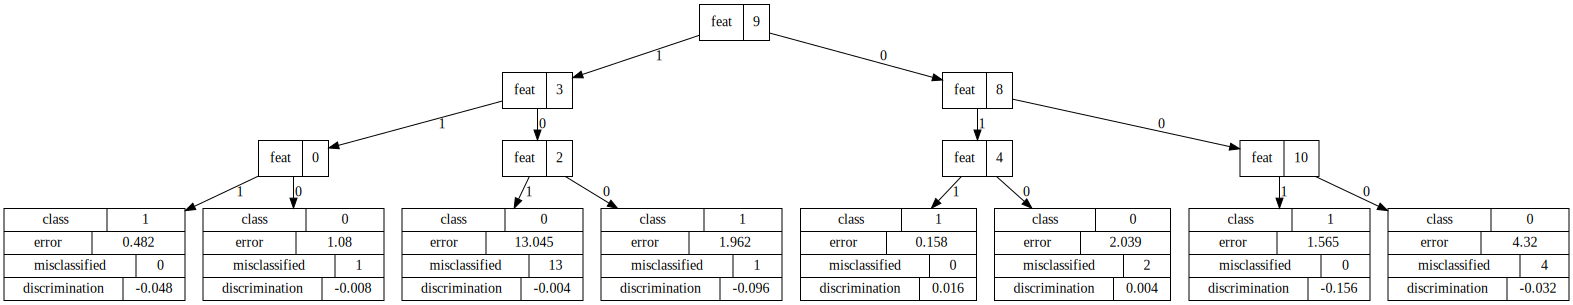

In [9]:
clf = DL85Classifier(max_depth=3, error_function=lambda tids: utils.error(list(tids), 10, y_train, sensitive_train), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
utils.tree_upgrade(clf.tree_, y_train, sensitive_train)
dot = utils.export_graphviz(clf)
graph = graphviz.Source(dot, format="png")
graph.render("plots/"+FILE_NAME+"tree")
graphviz.Source(dot)


In [10]:
utils.sum_elem_tree(clf.tree_, 'discrimination_additive', s=list(), bool=False)

0.36504761904761907

In [11]:
utils.sum_elem_tree(clf.tree_, 'misclassified', s=list(), bool=False)

21

In [12]:
y_pred_train = clf.predict(X_train)
discrimation_train = utils.discrimination(y_train, sensitive_train)
discrimation_train

-0.32561904761904764

# Graphs

<Figure size 648x432 with 0 Axes>

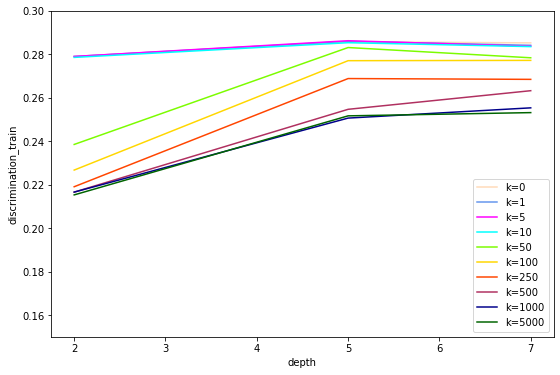

In [13]:
utils.plot_mean("depth", "discrimination_train", result, 0.15, 0.3)

<Figure size 648x432 with 0 Axes>

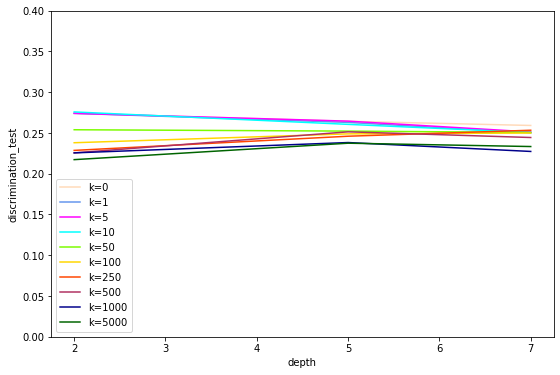

In [14]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4)

<Figure size 648x432 with 0 Axes>

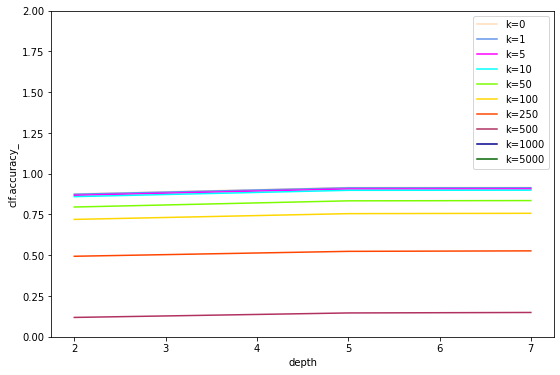

In [15]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

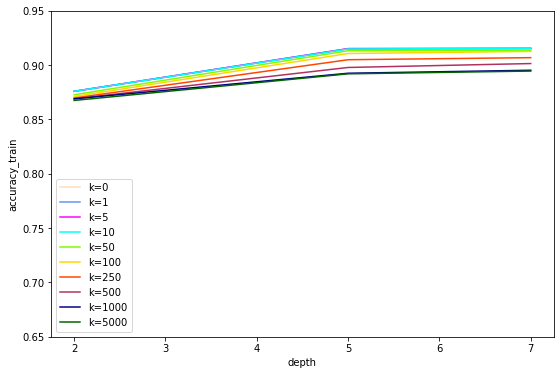

In [16]:
utils.plot_mean("depth", "accuracy_train", result, 0.65, 0.95)

<Figure size 648x432 with 0 Axes>

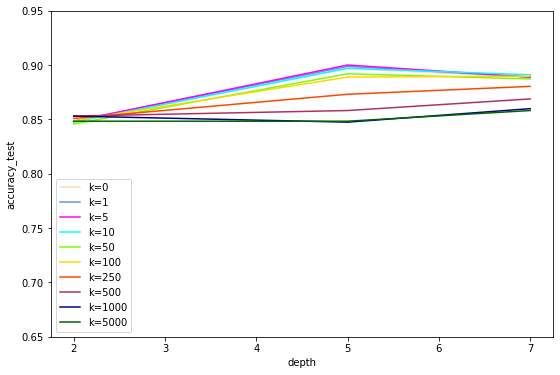

In [17]:
utils.plot_mean("depth", "accuracy_test", result, 0.65, 0.95)

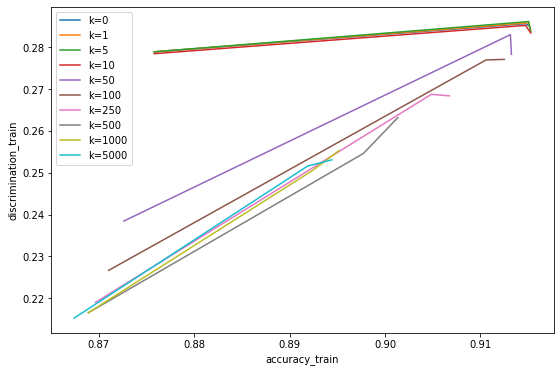

In [18]:
utils.plot2("accuracy_train", "discrimination_train", result)

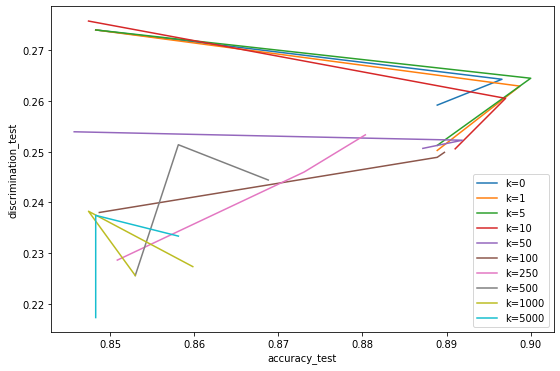

In [19]:
utils.plot2("accuracy_test", "discrimination_test", result)

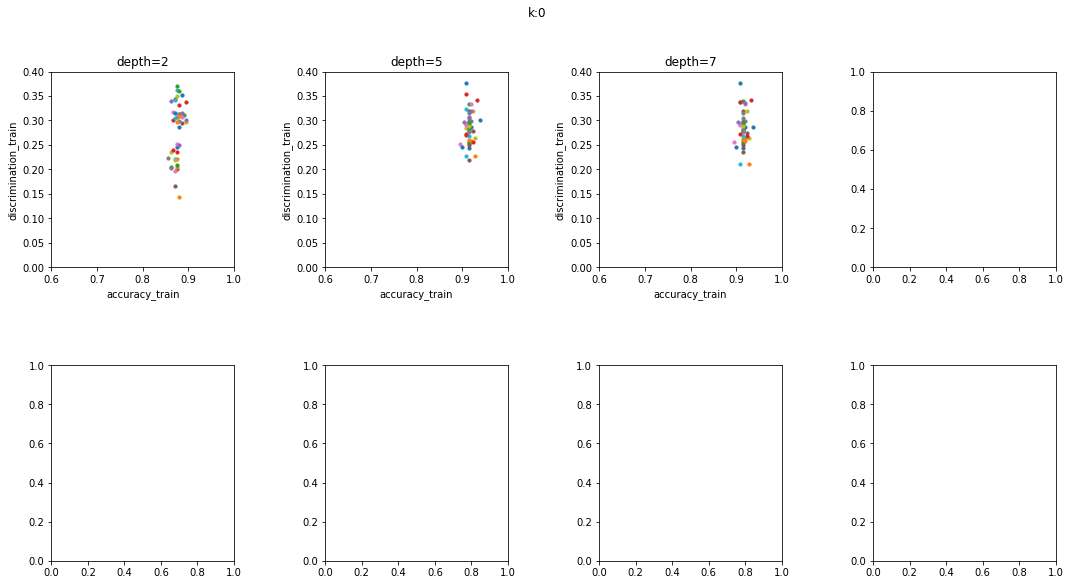

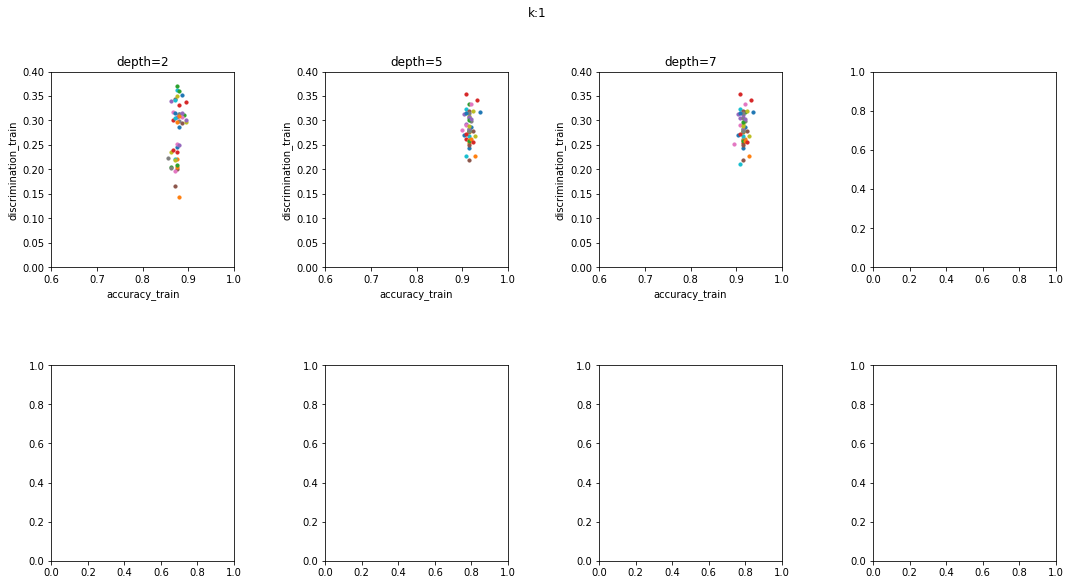

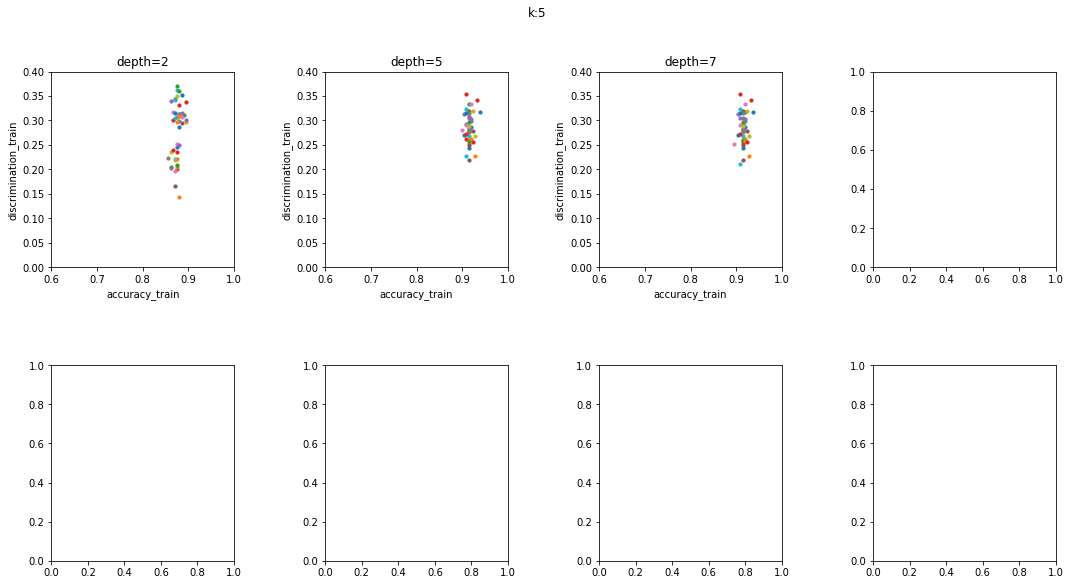

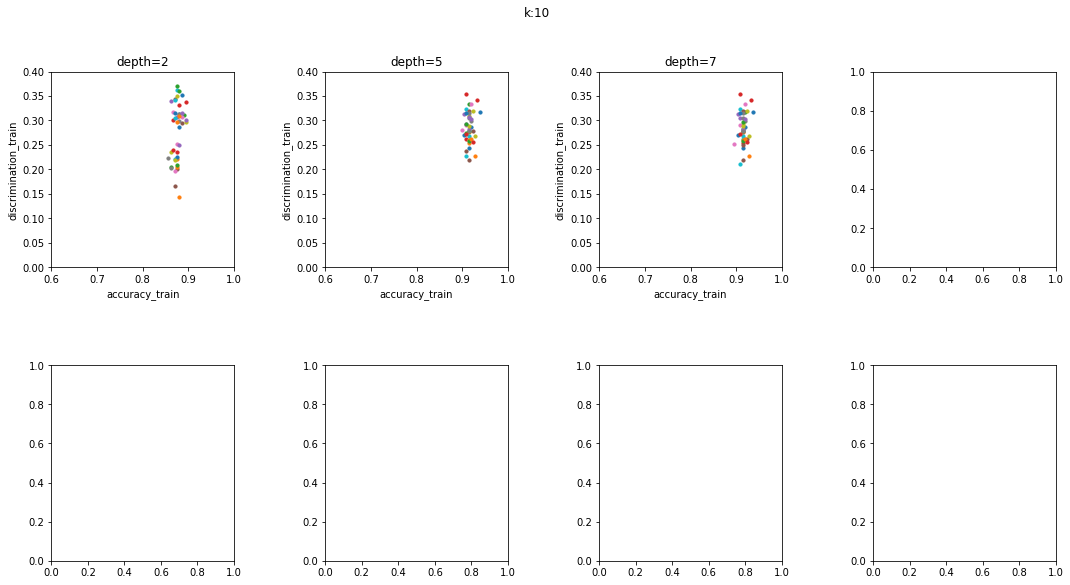

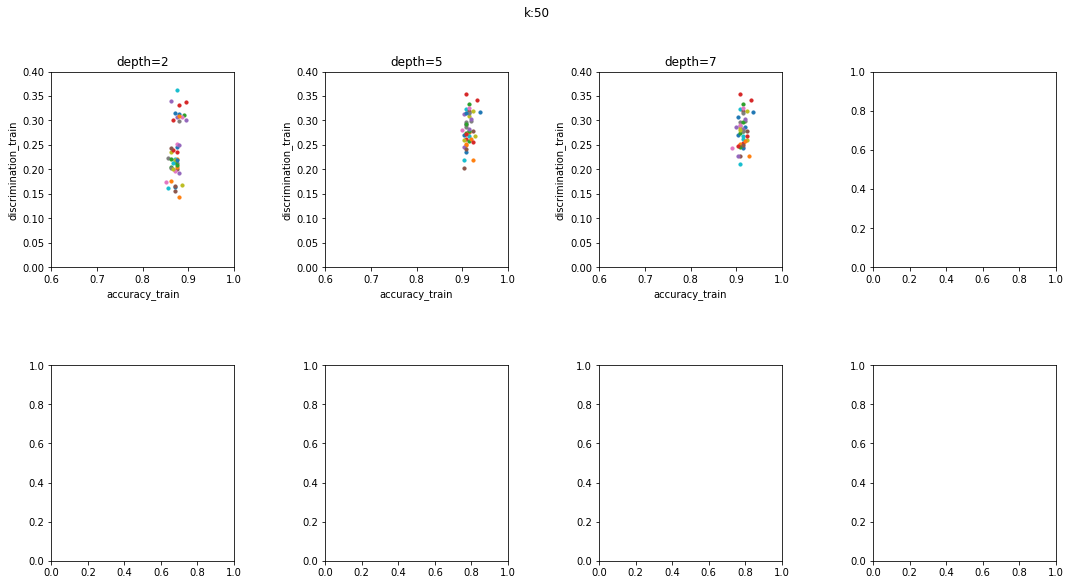

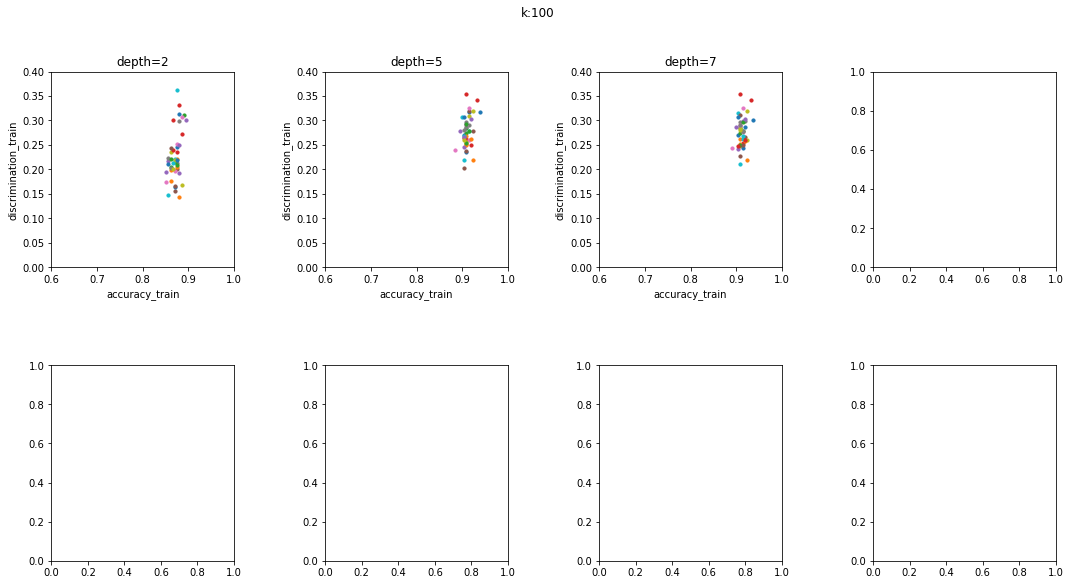

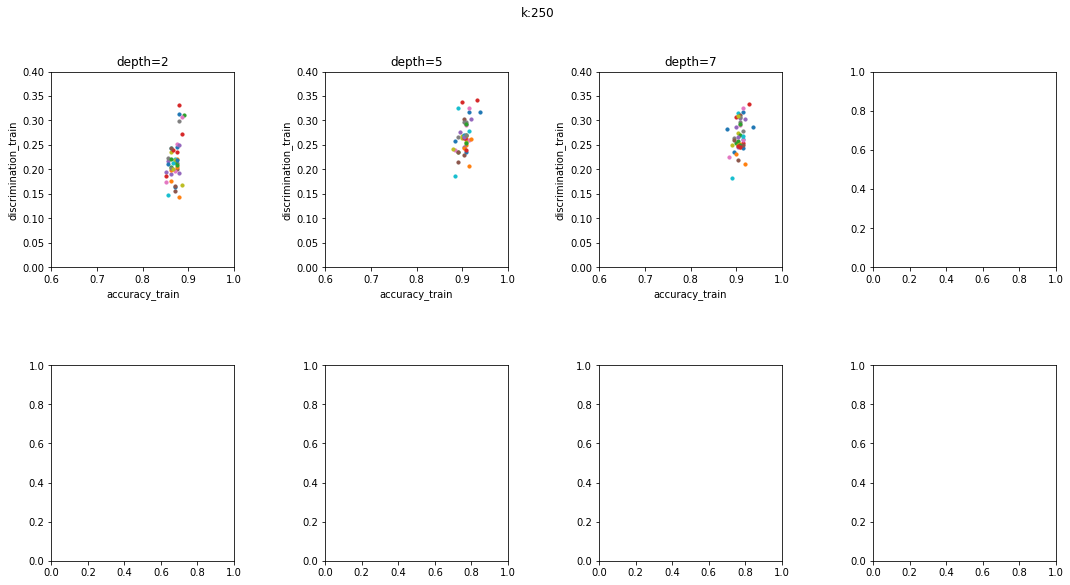

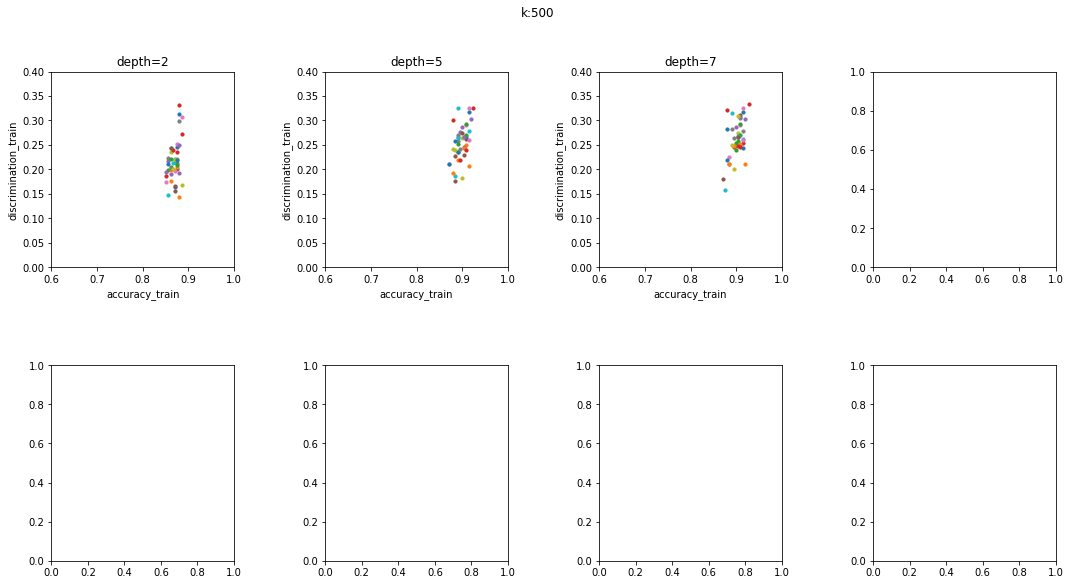

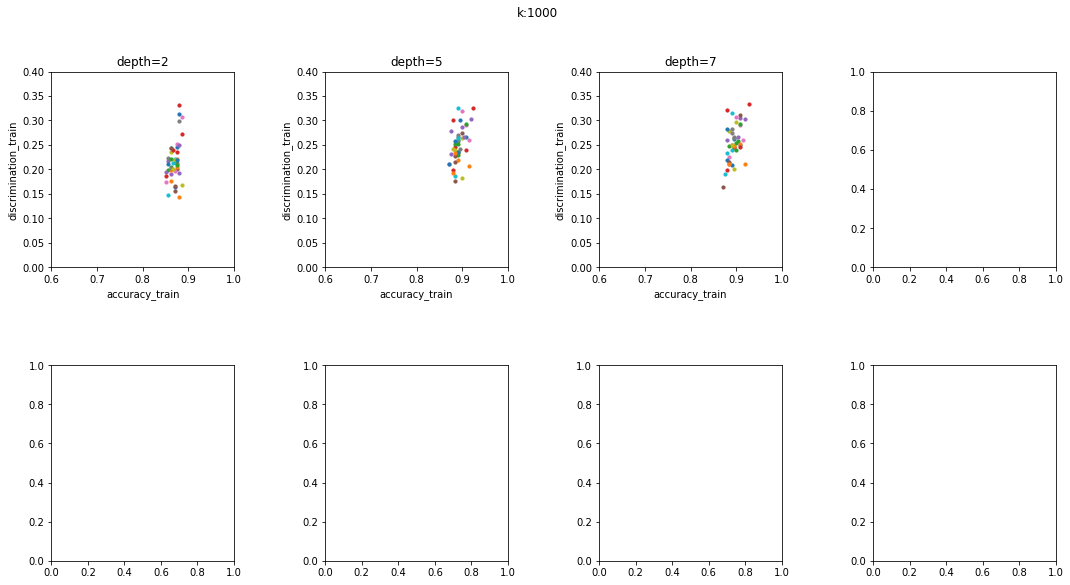

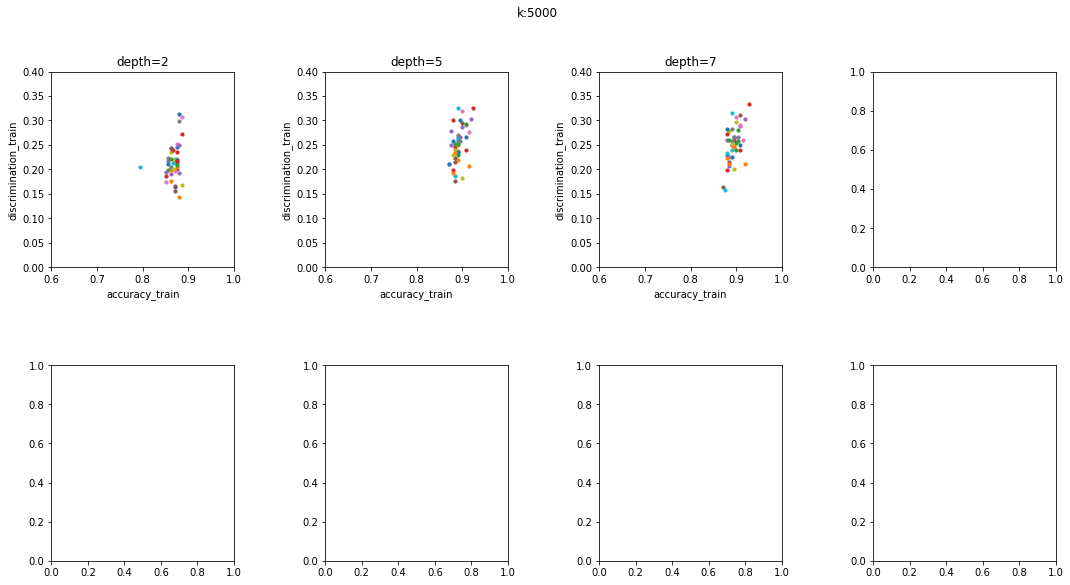

In [20]:
utils.plot_one_scatter_by_depth("accuracy_train", "discrimination_train", result, (0.6, 1), (0, 0.4))

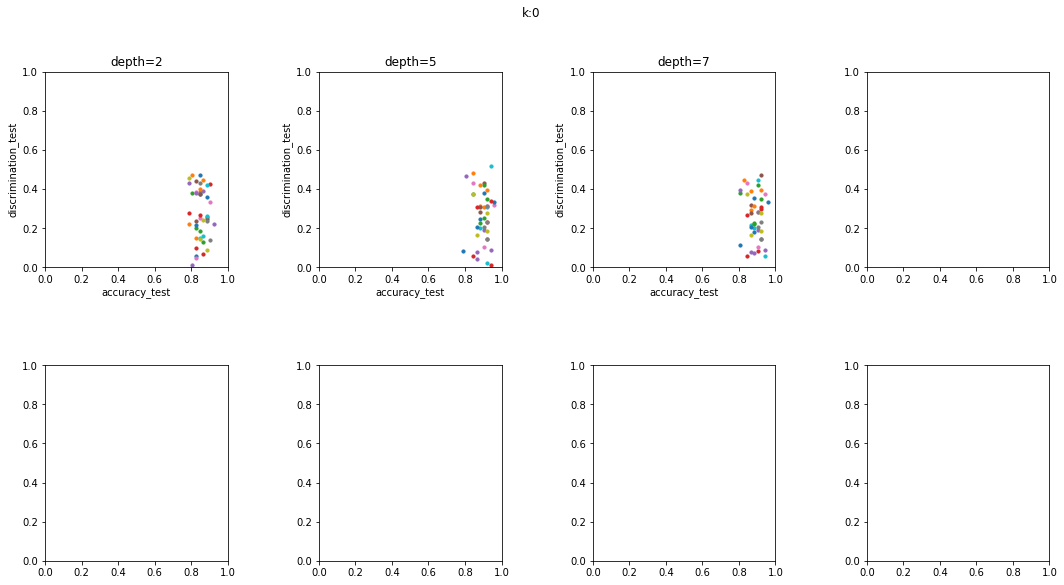

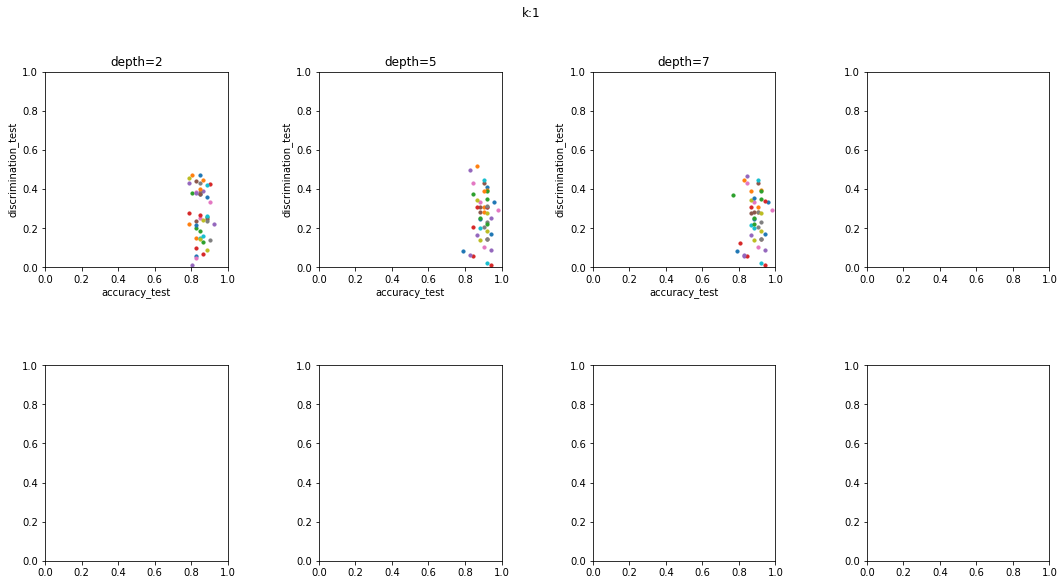

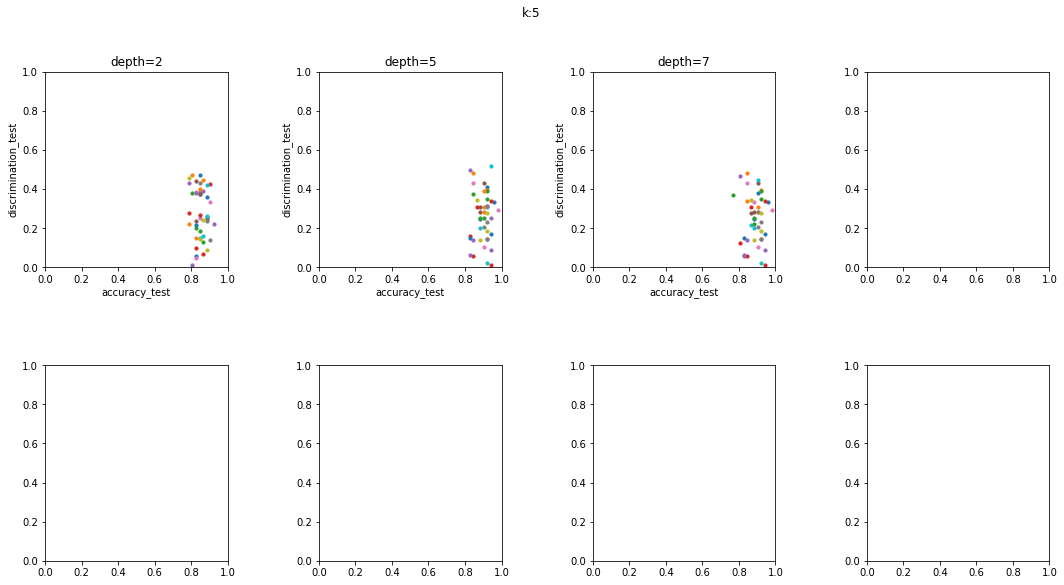

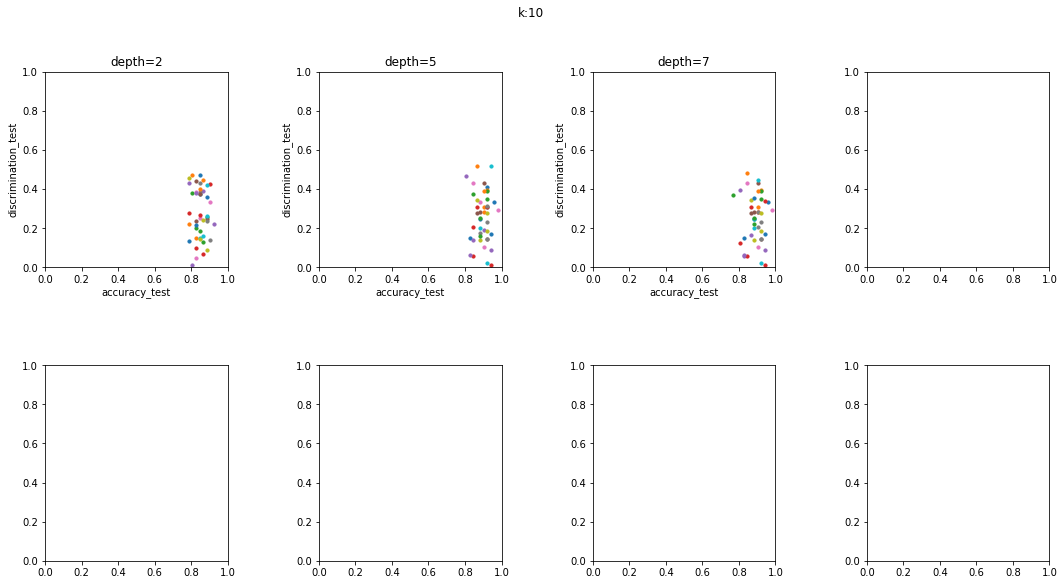

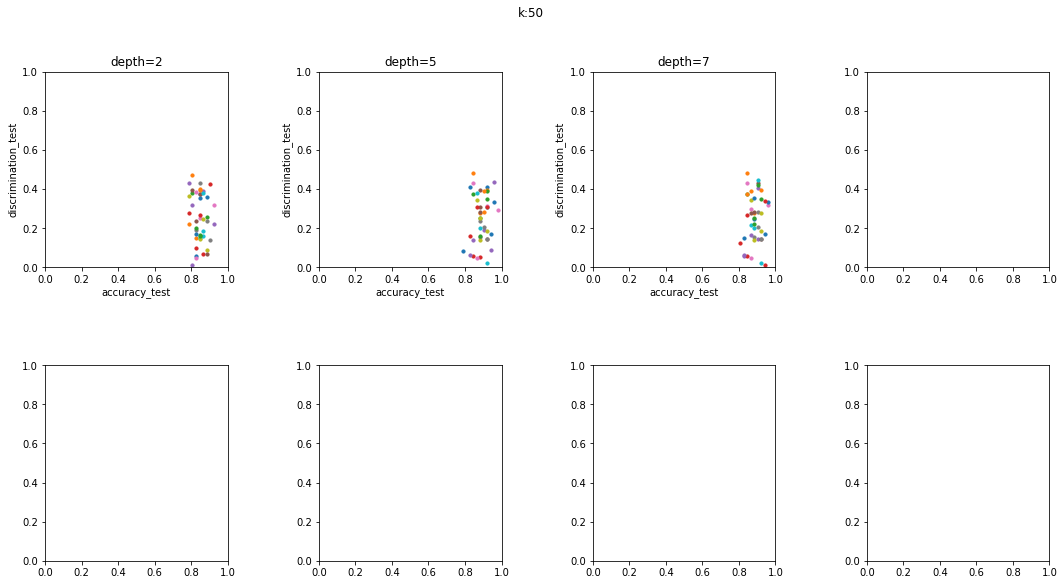

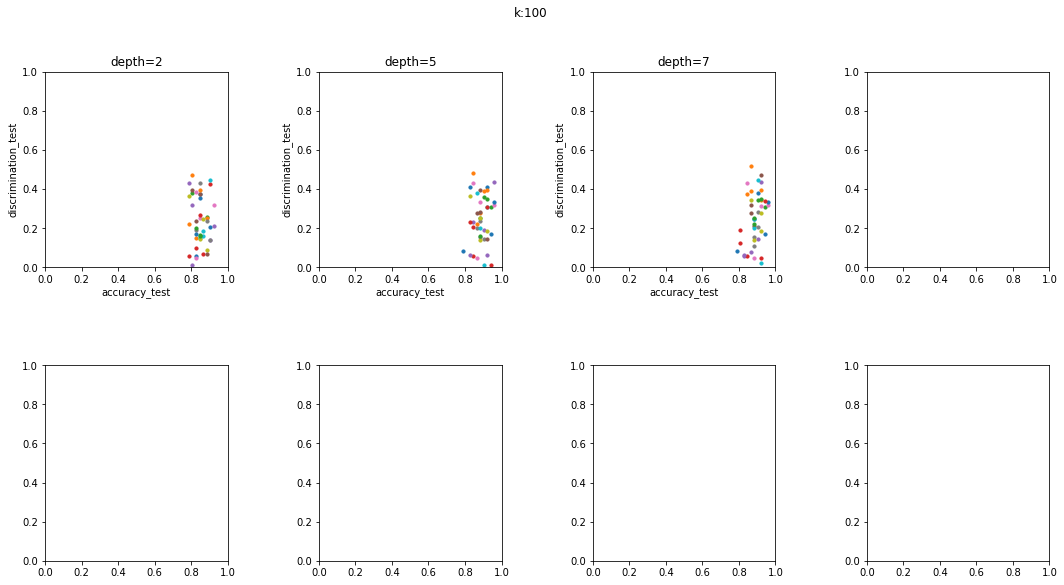

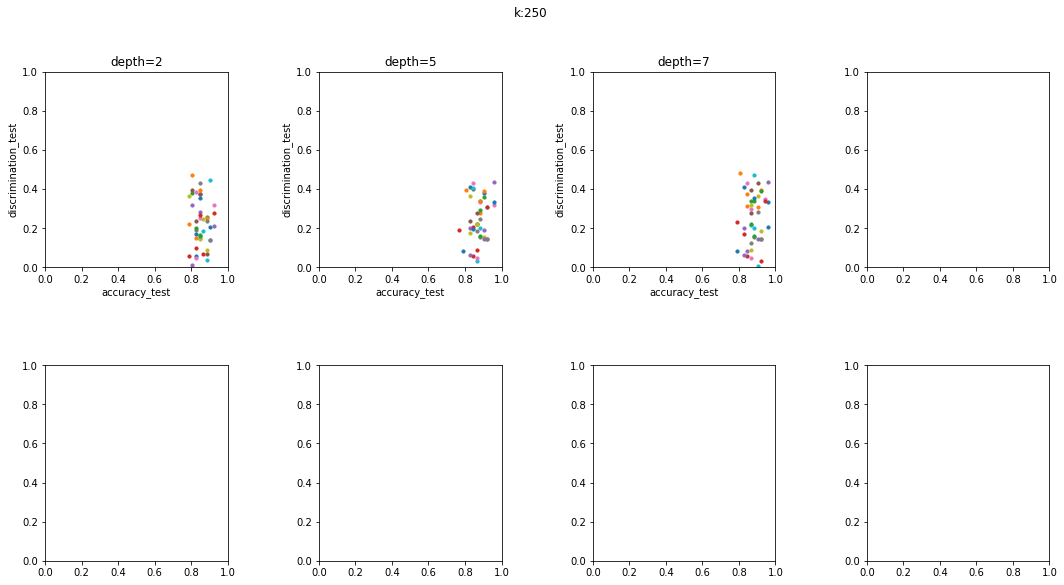

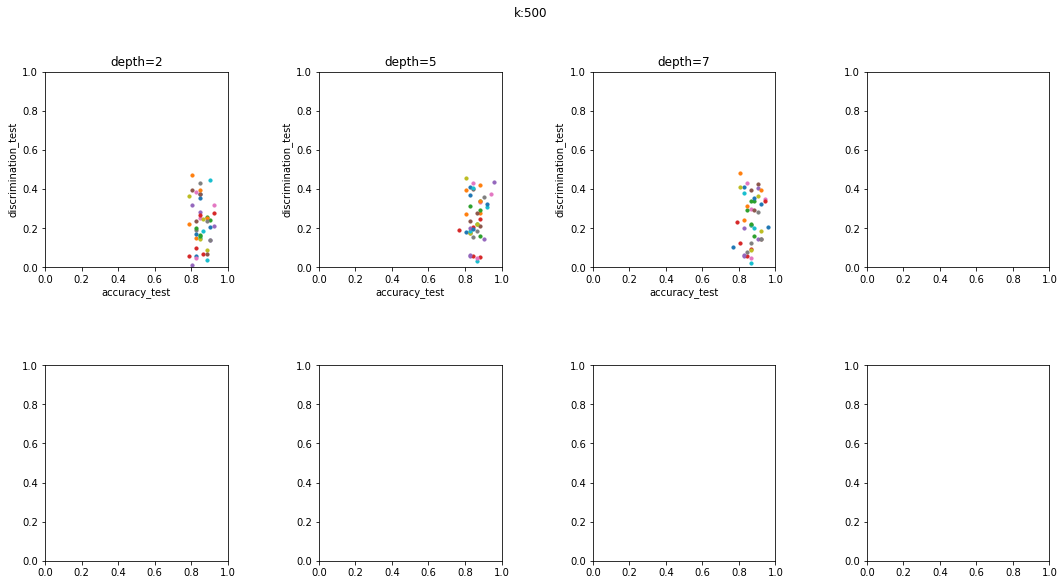

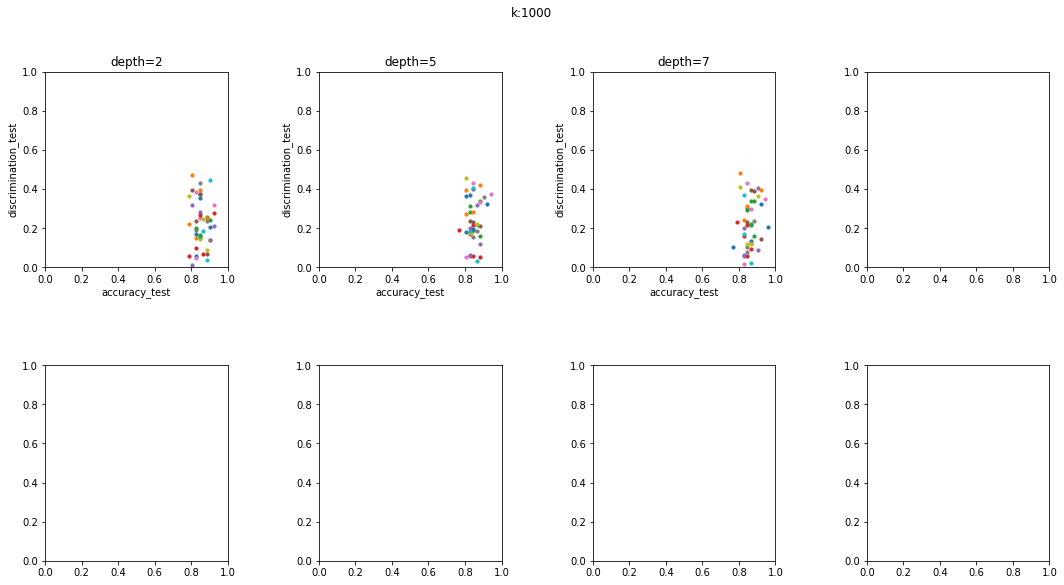

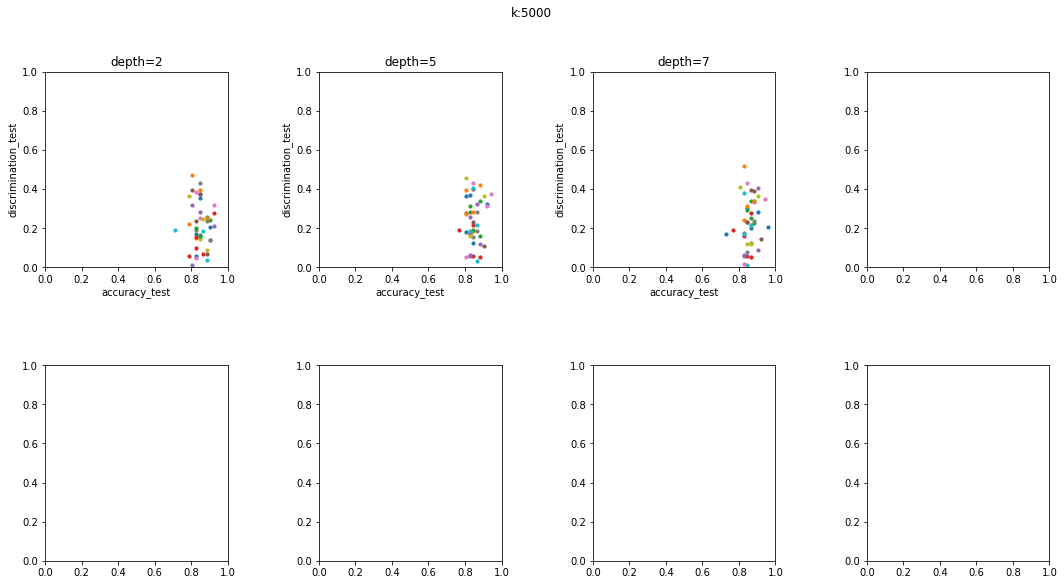

In [21]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

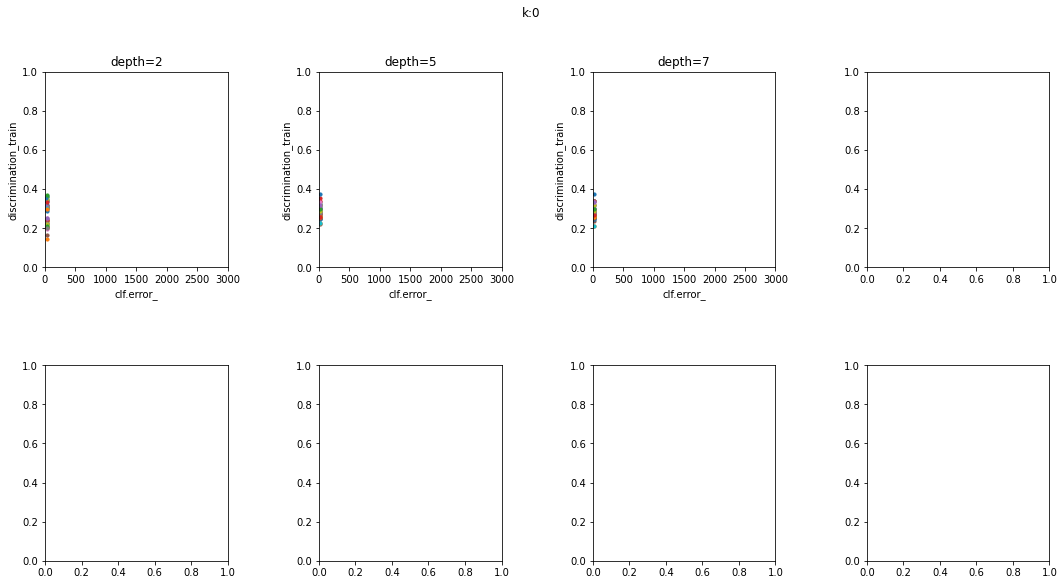

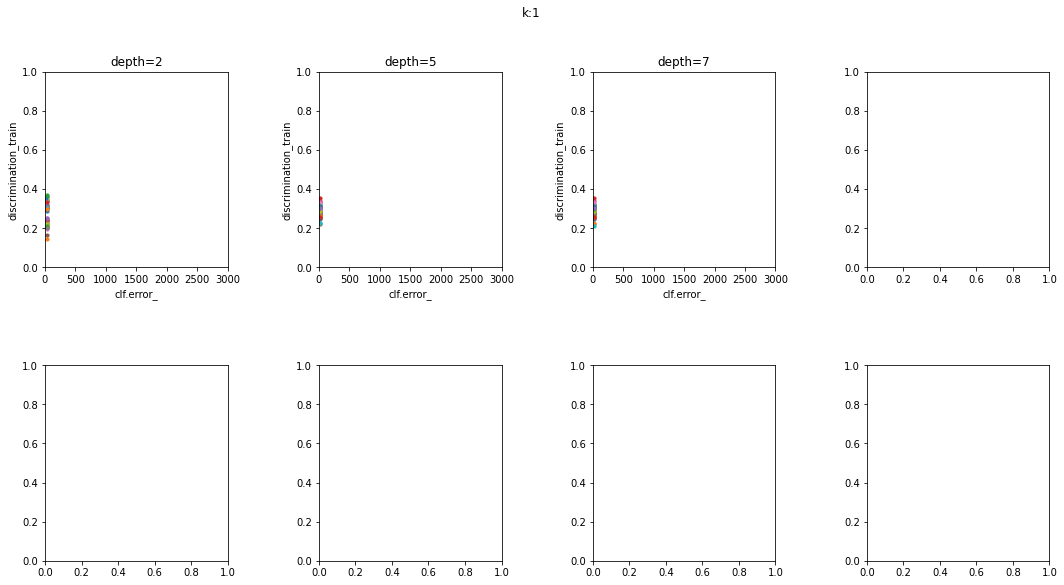

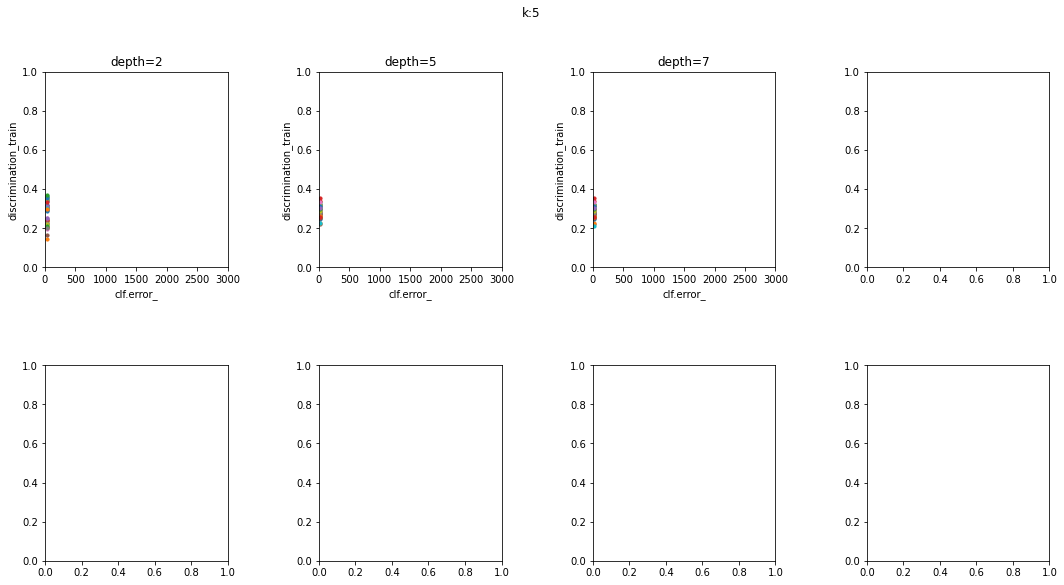

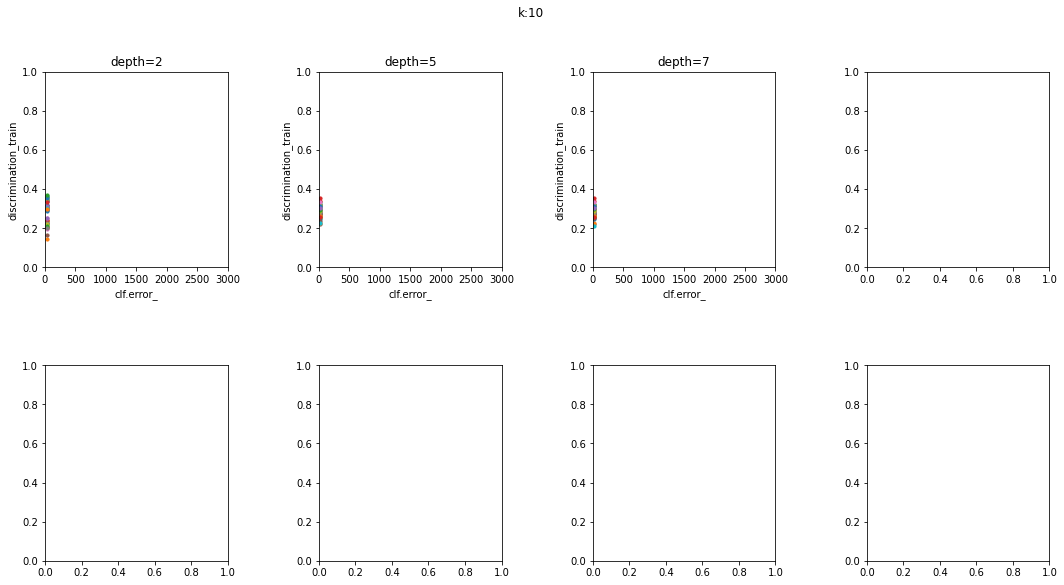

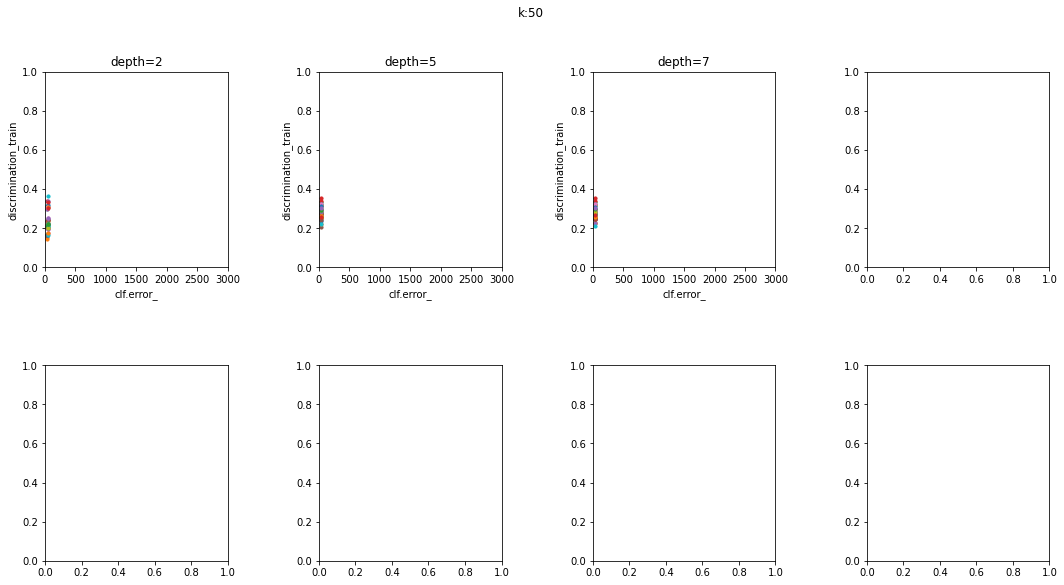

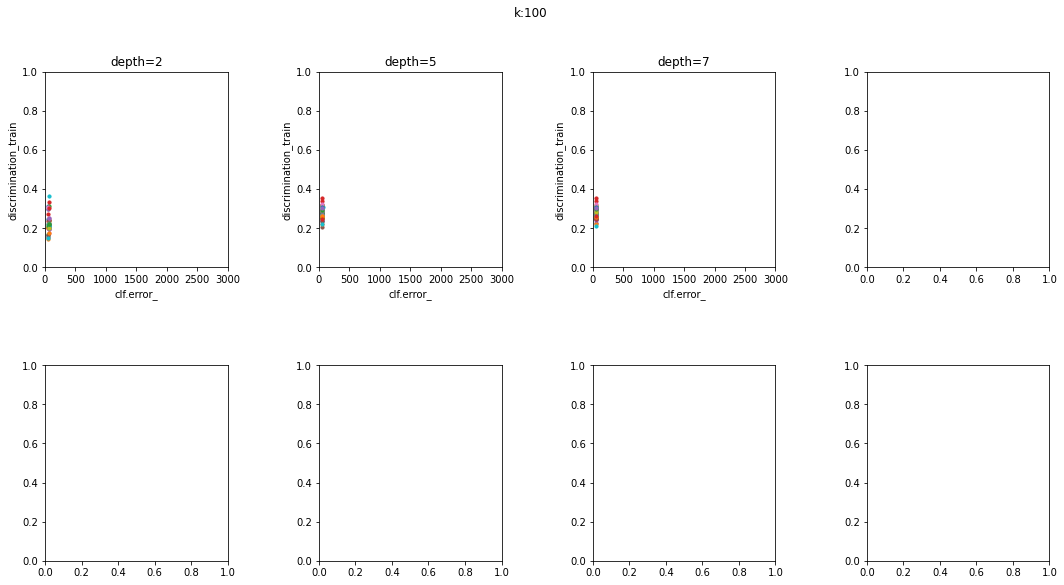

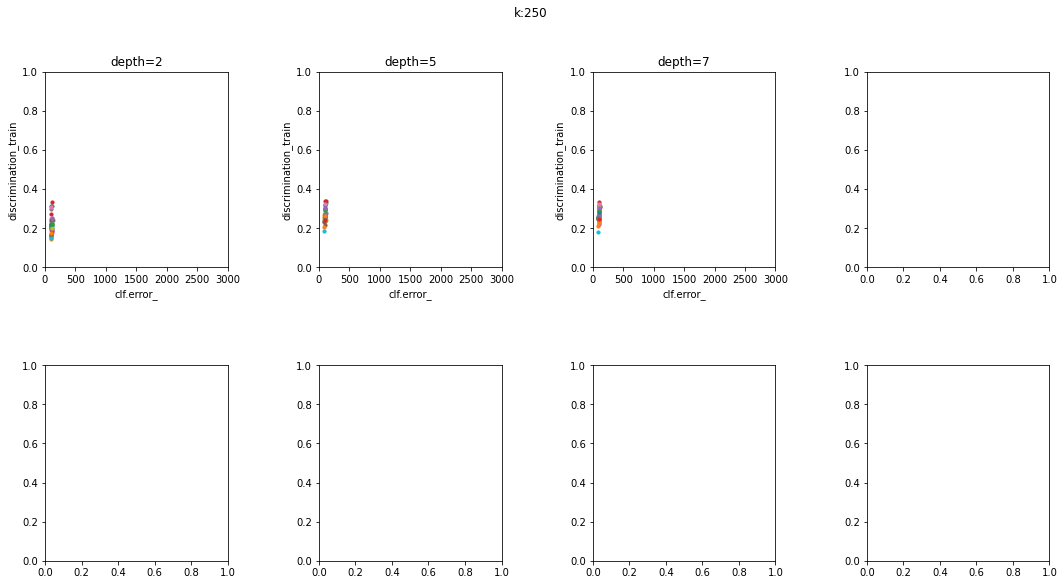

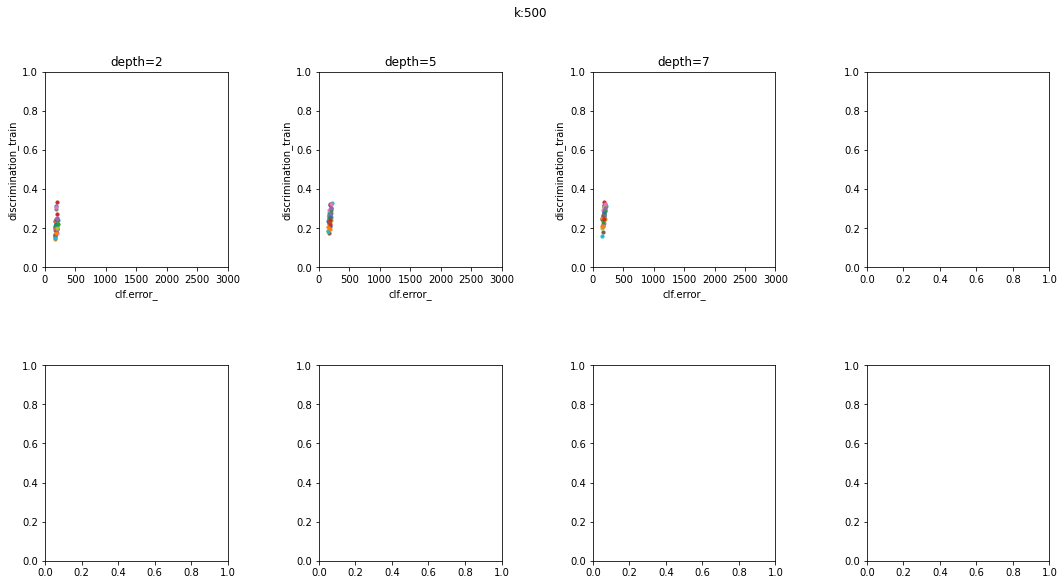

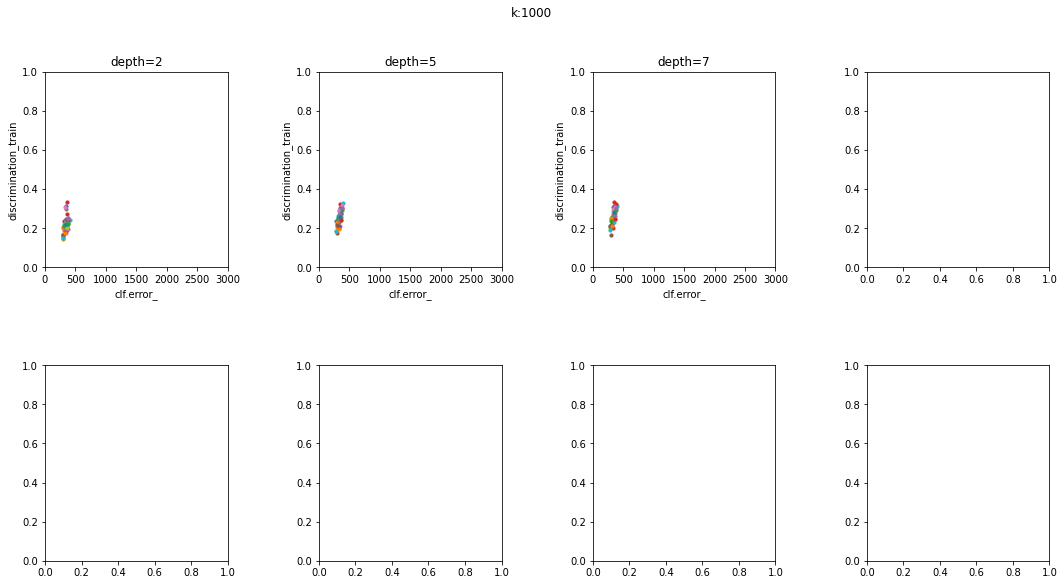

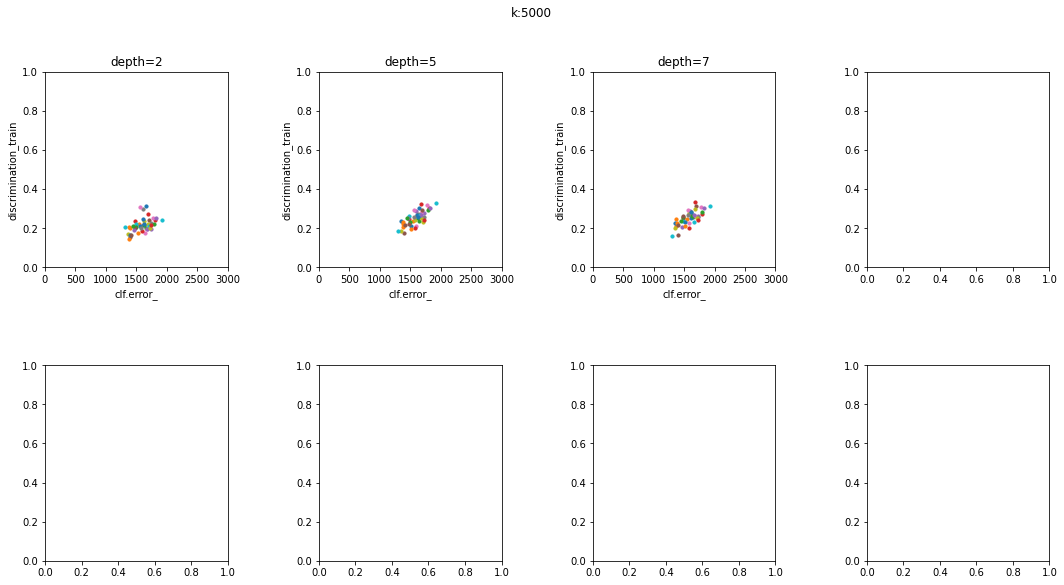

In [22]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train", result, (0, 3000), (0, 1))

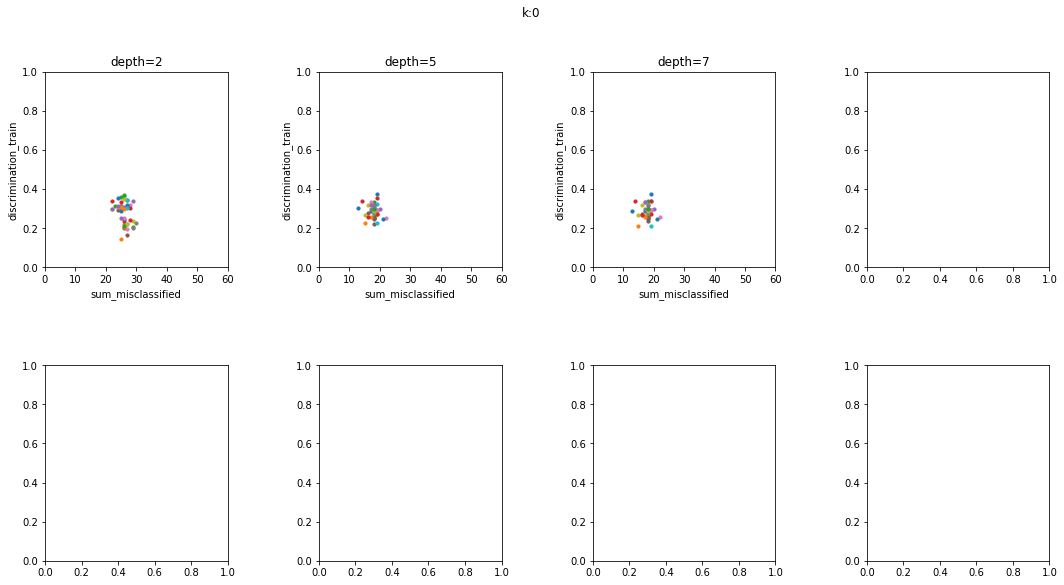

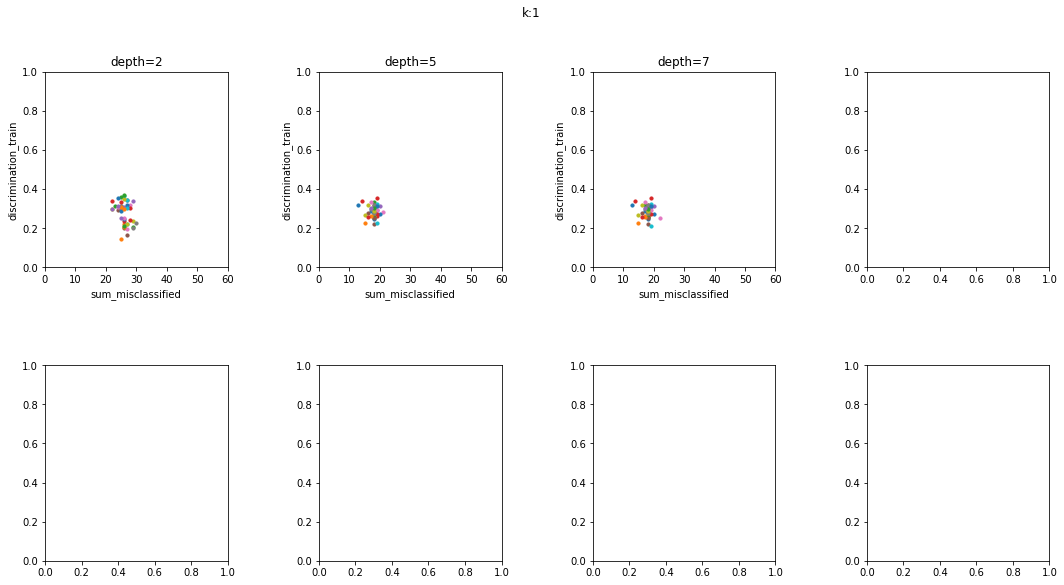

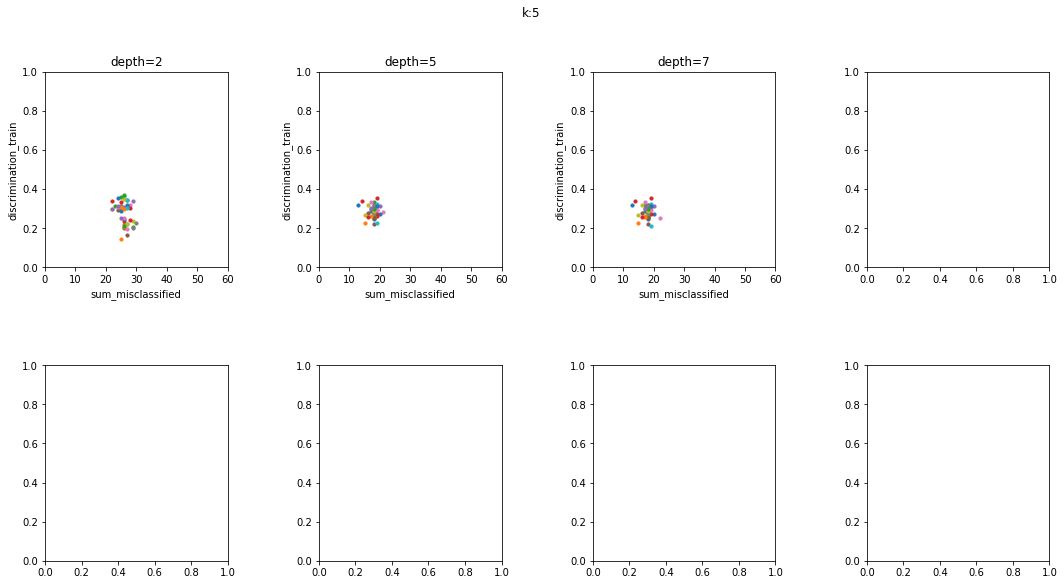

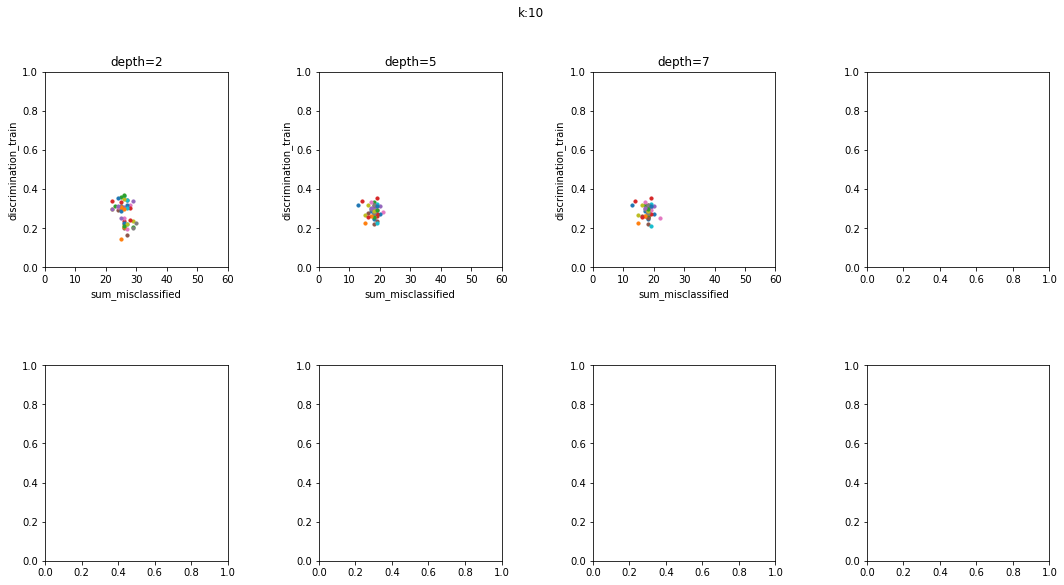

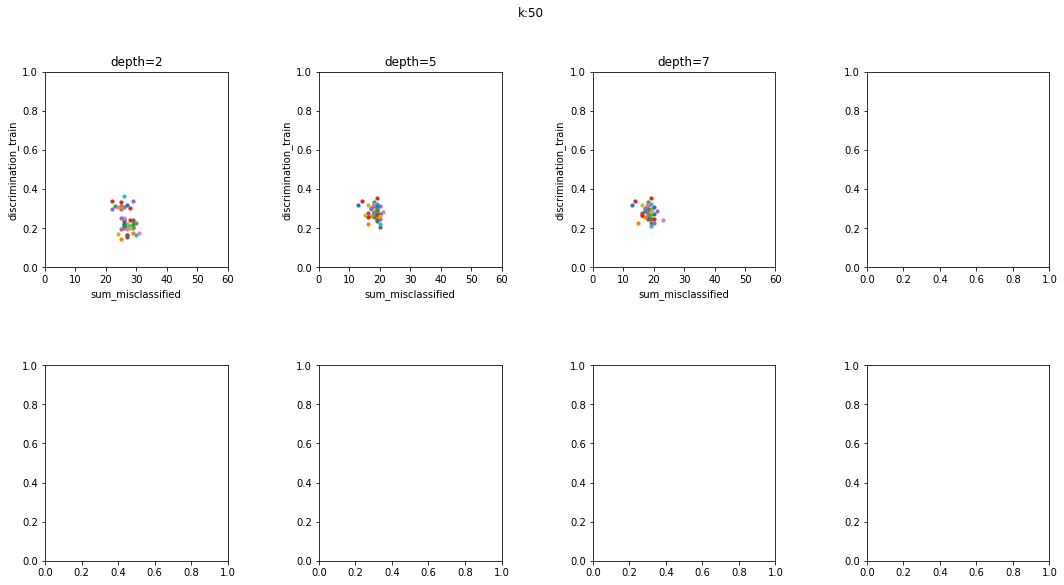

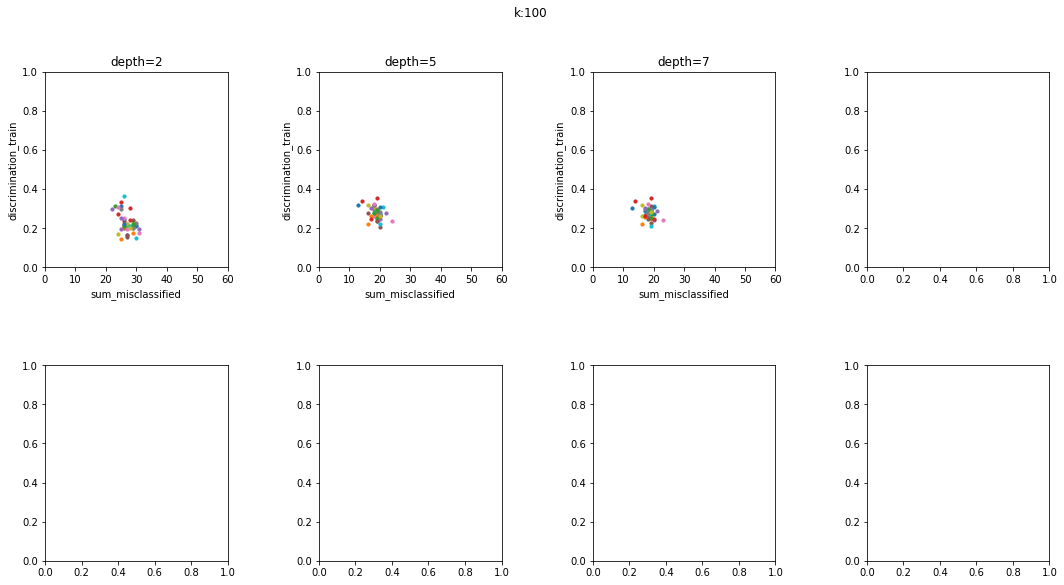

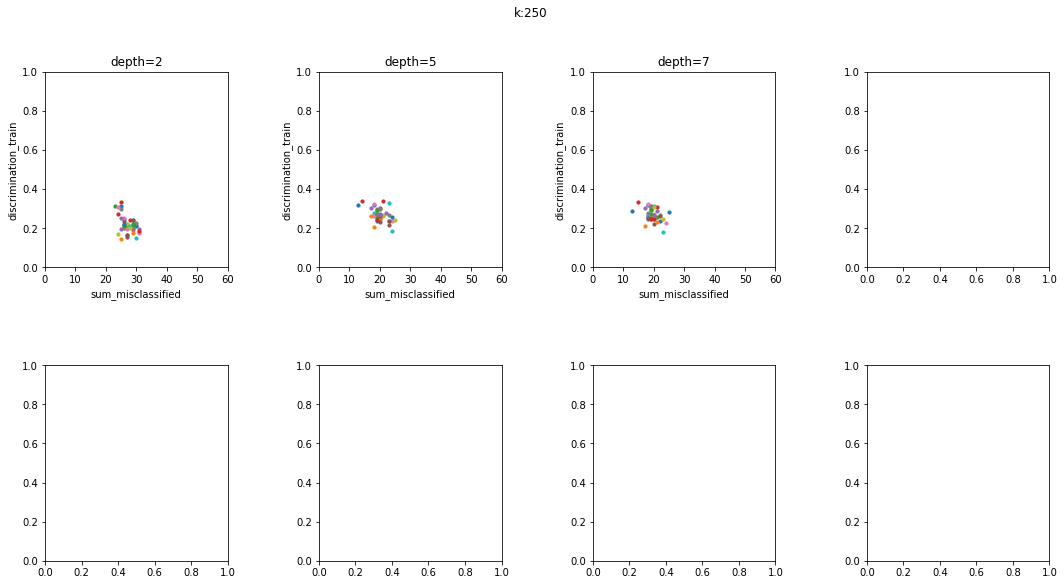

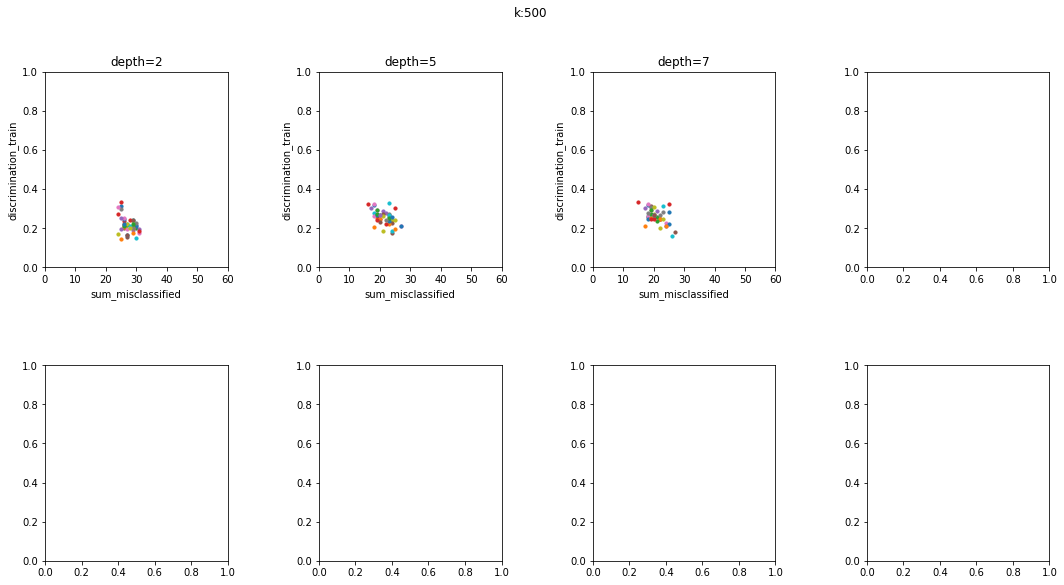

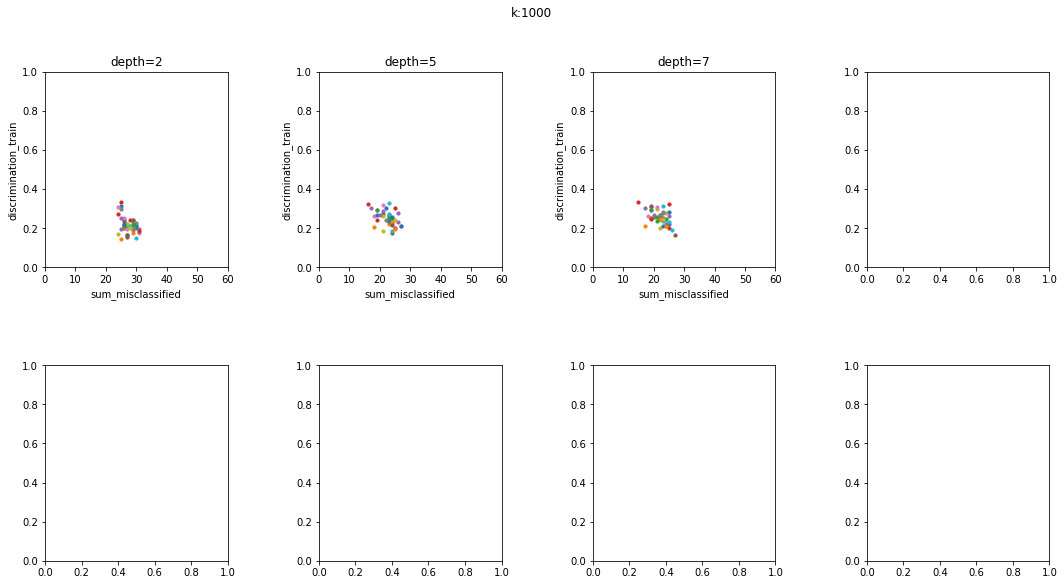

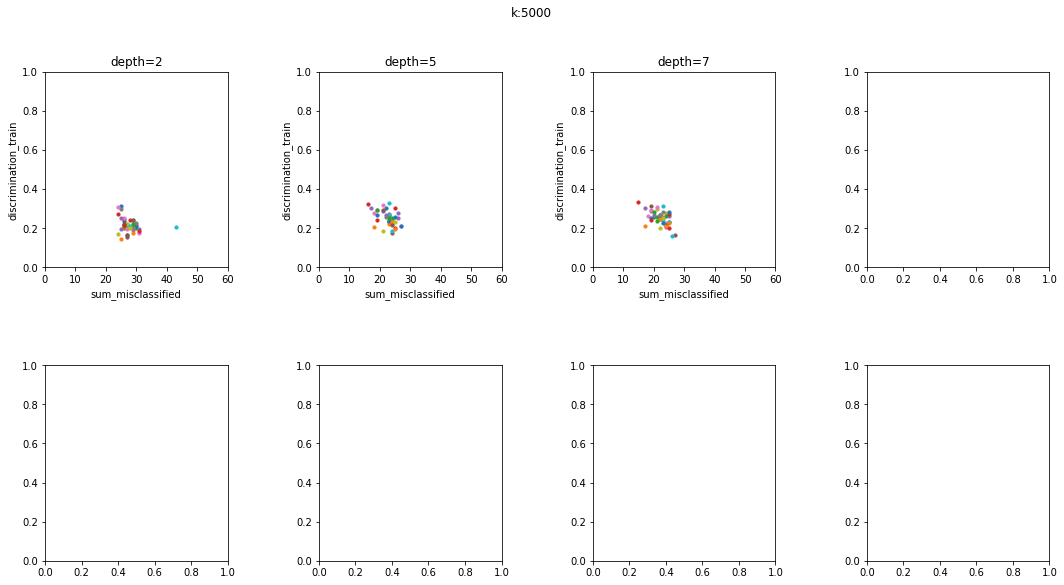

In [23]:
utils.plot_one_scatter_by_depth("sum_misclassified", "discrimination_train", result, (0, 60), (0, 1))

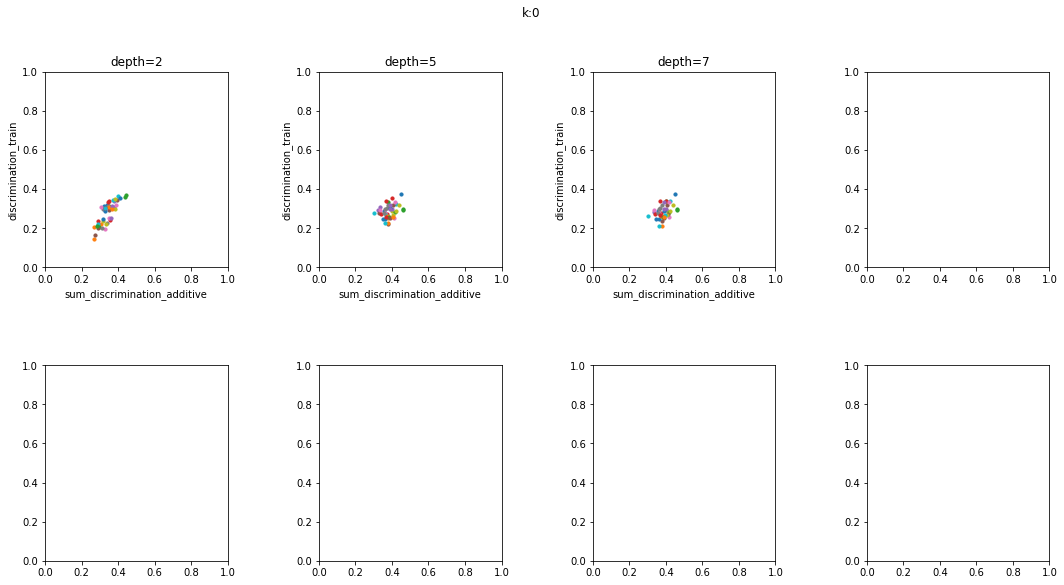

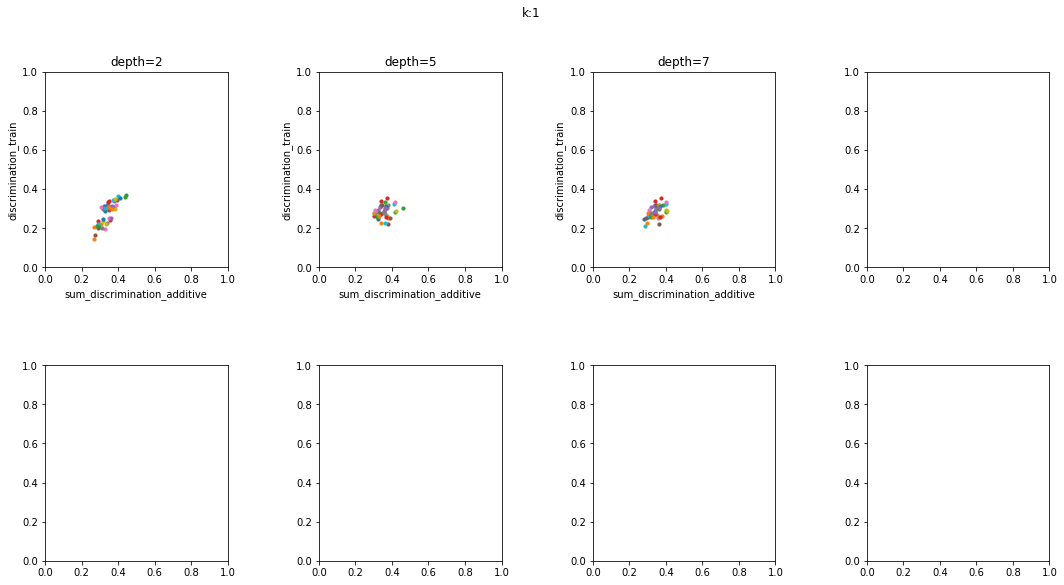

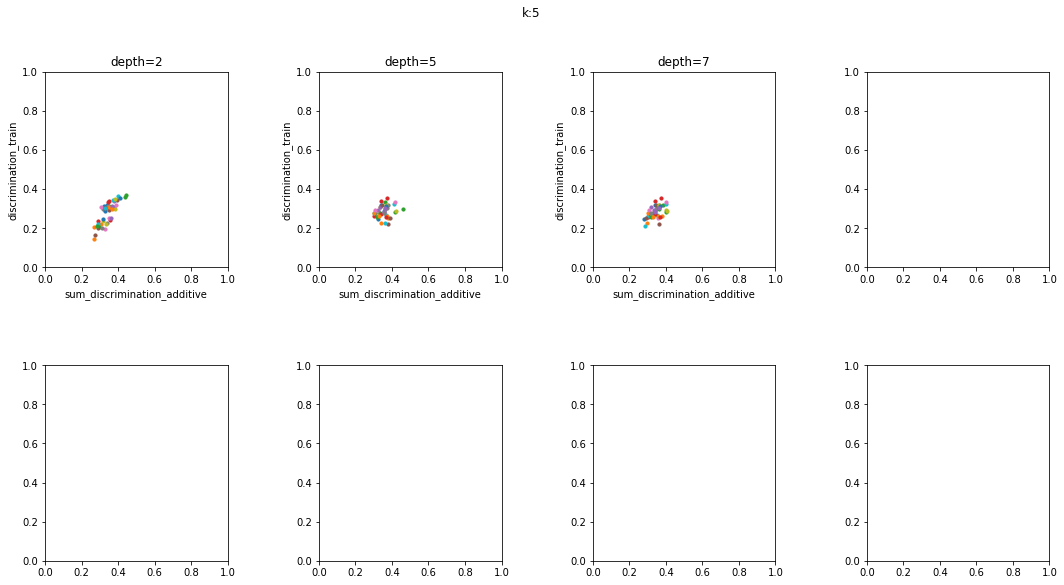

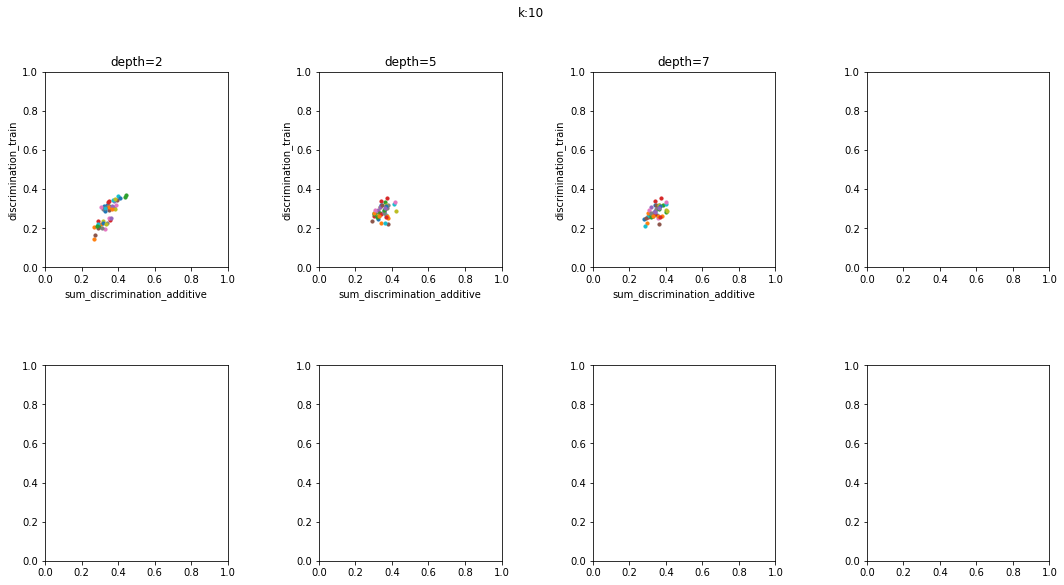

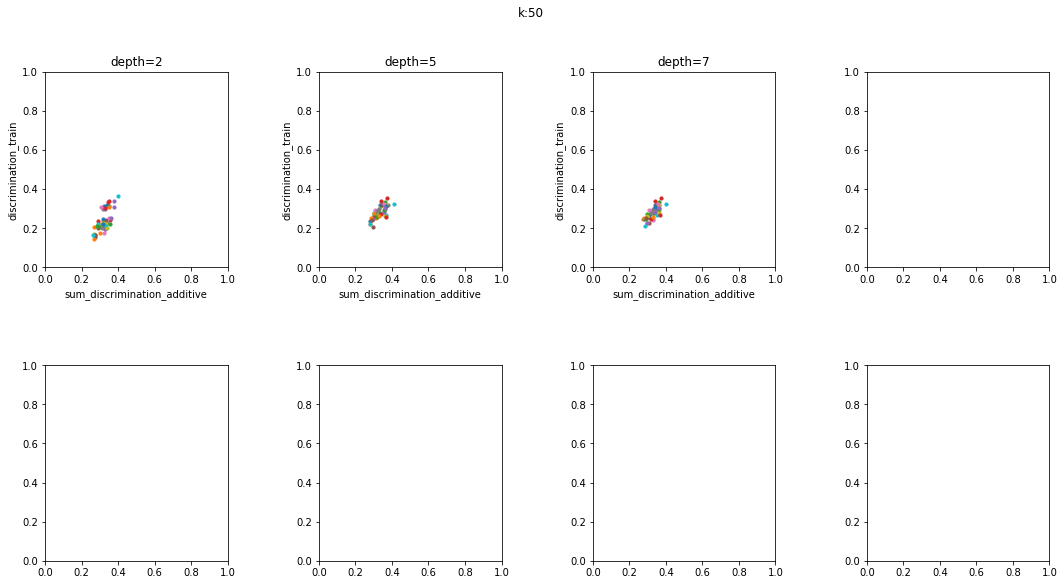

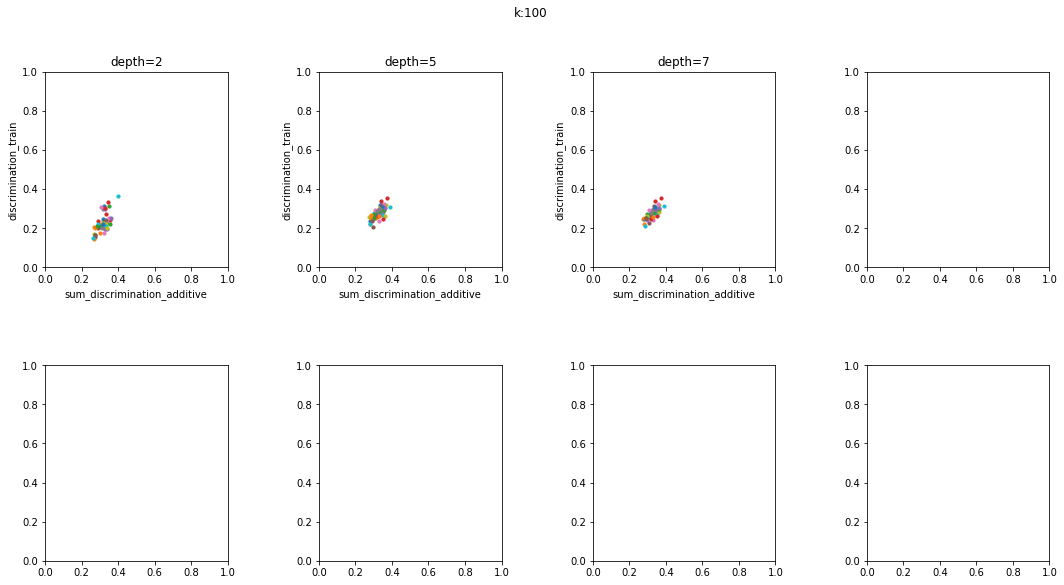

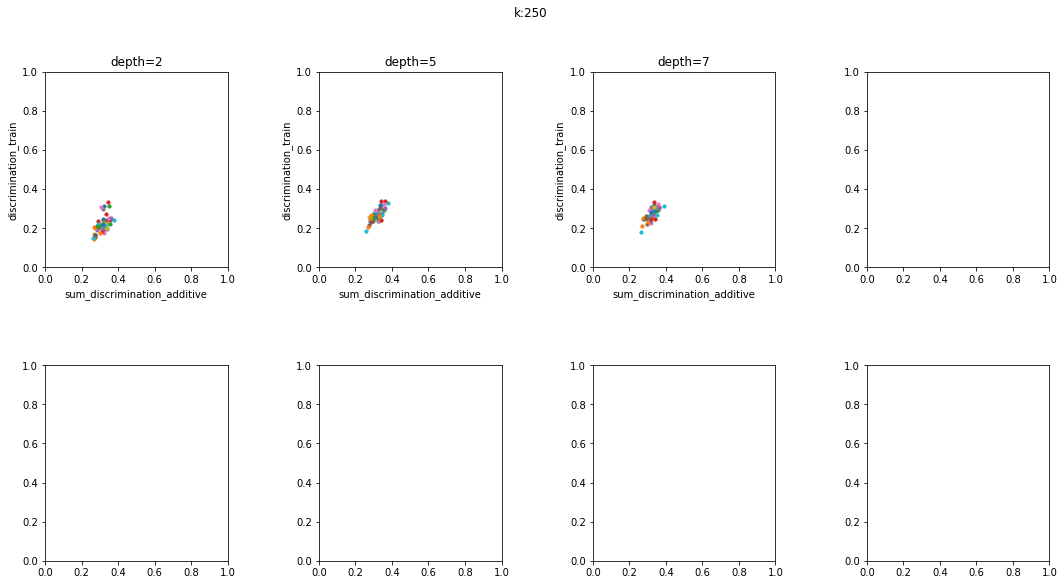

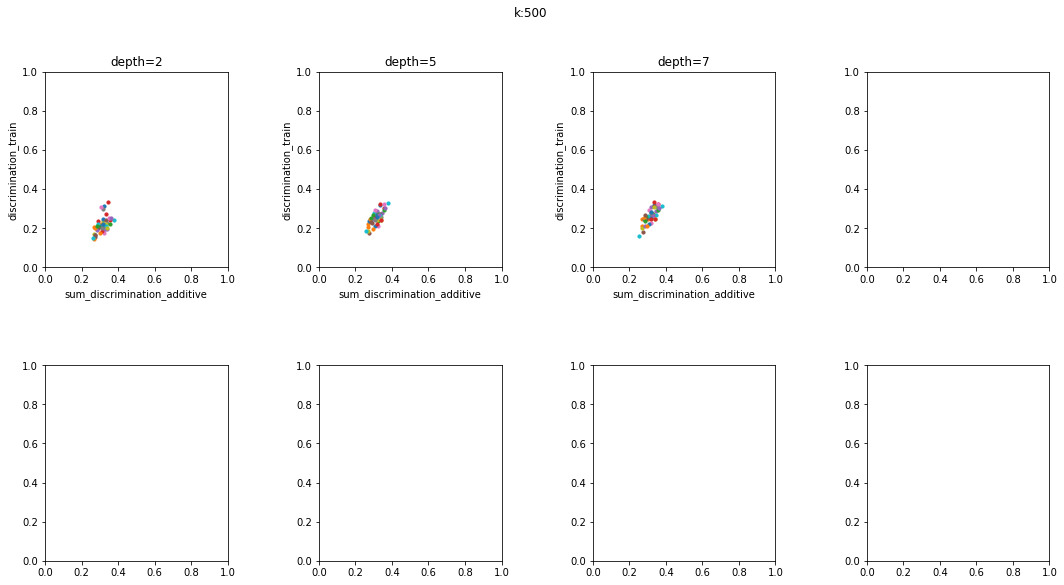

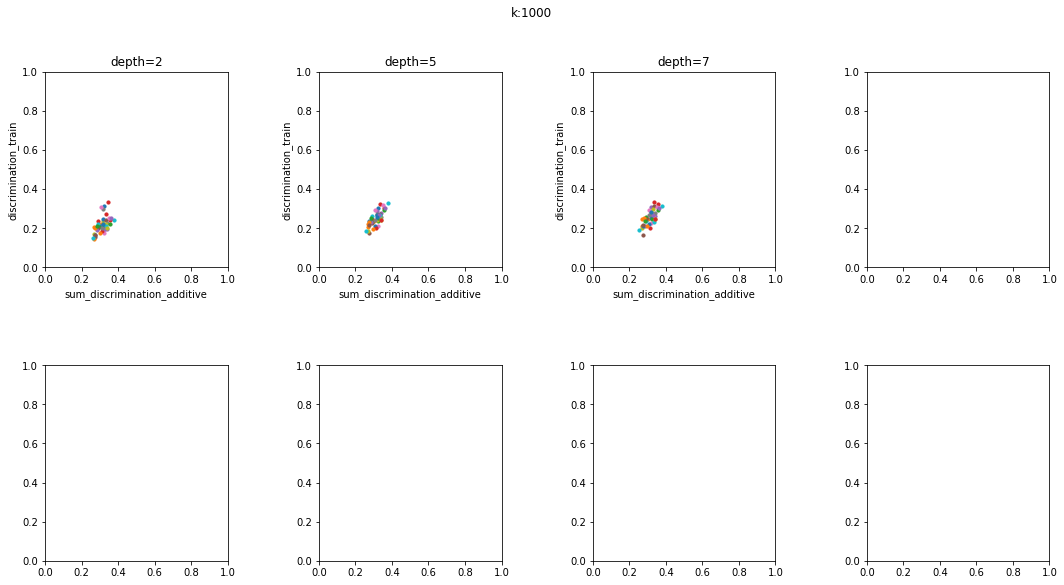

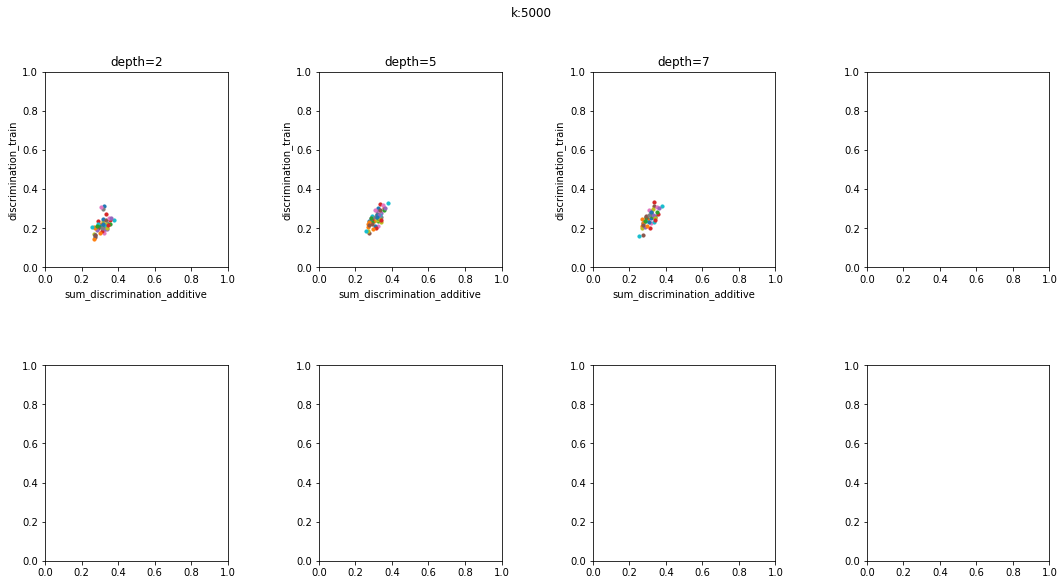

In [24]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive", "discrimination_train", result, (0, 1), (0, 1))

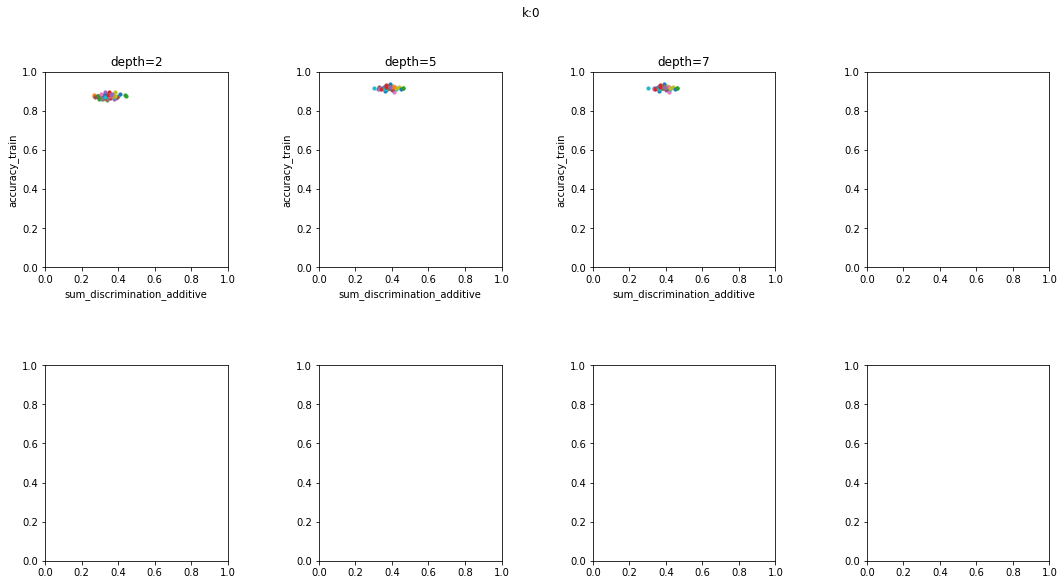

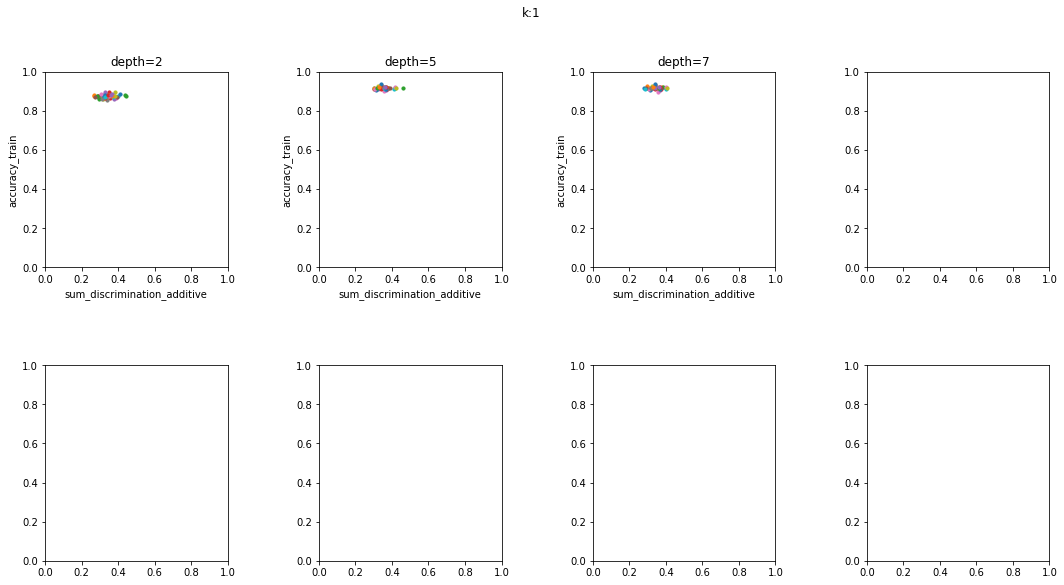

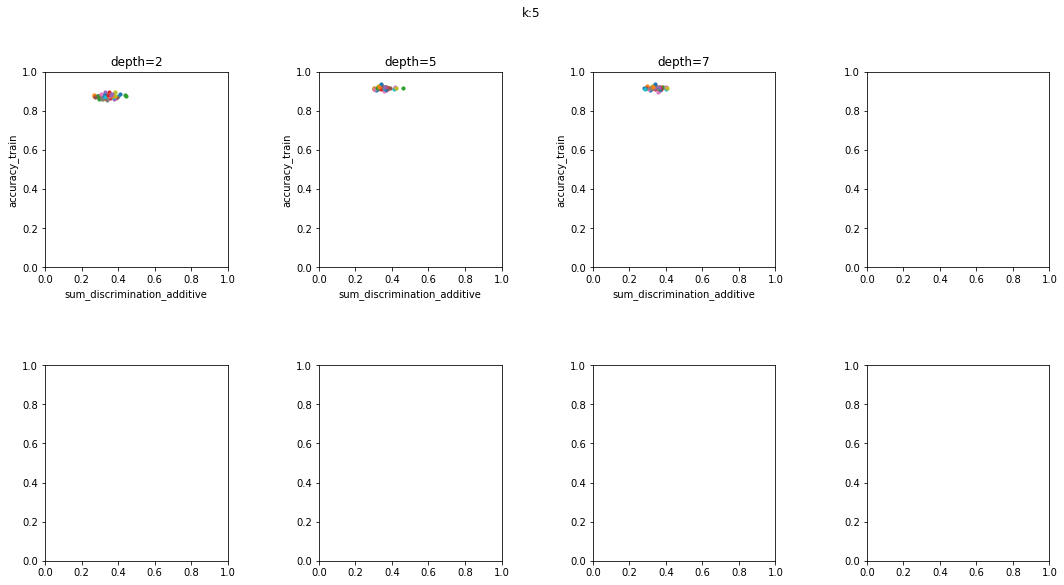

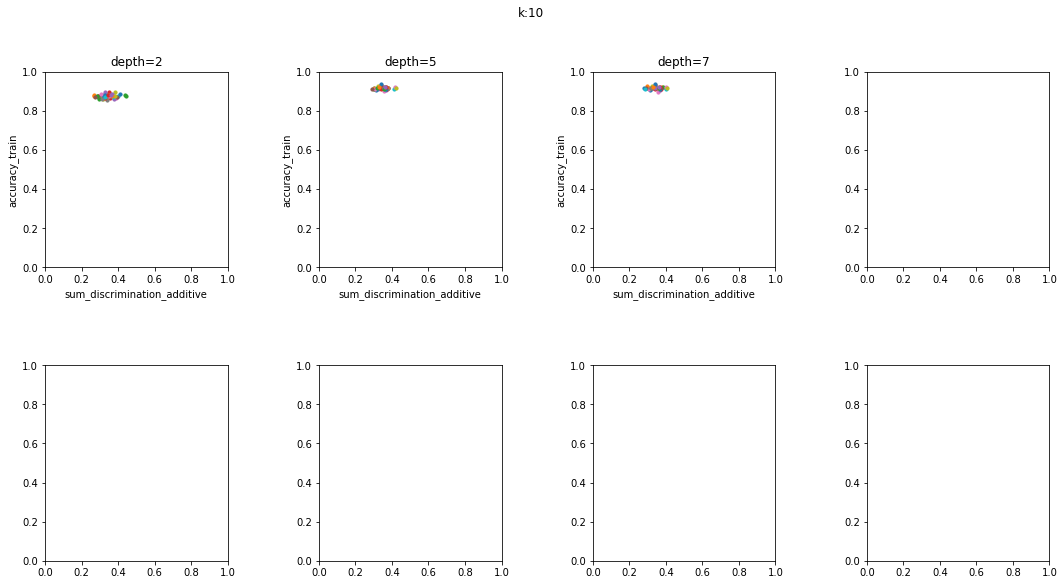

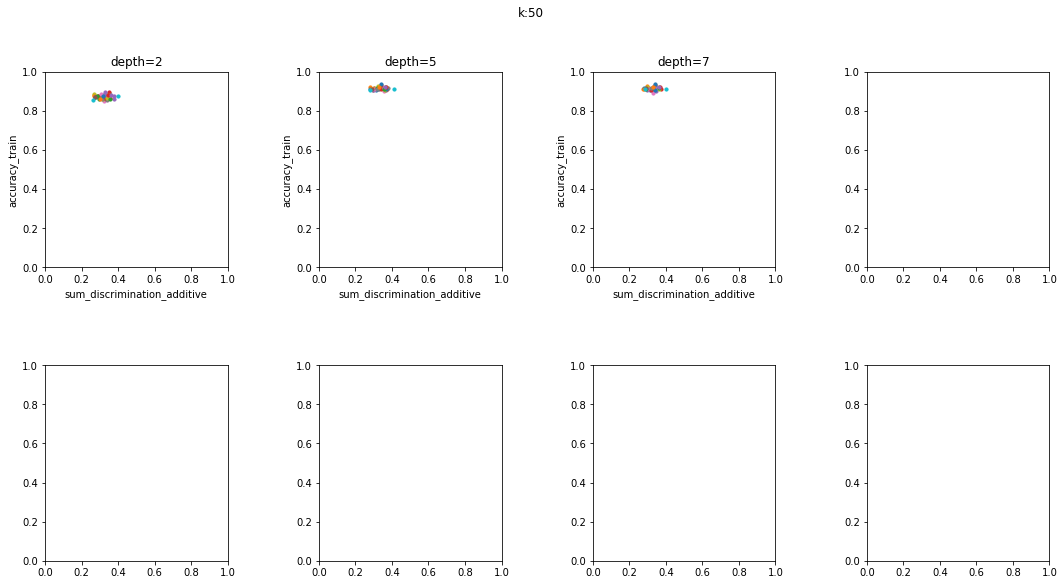

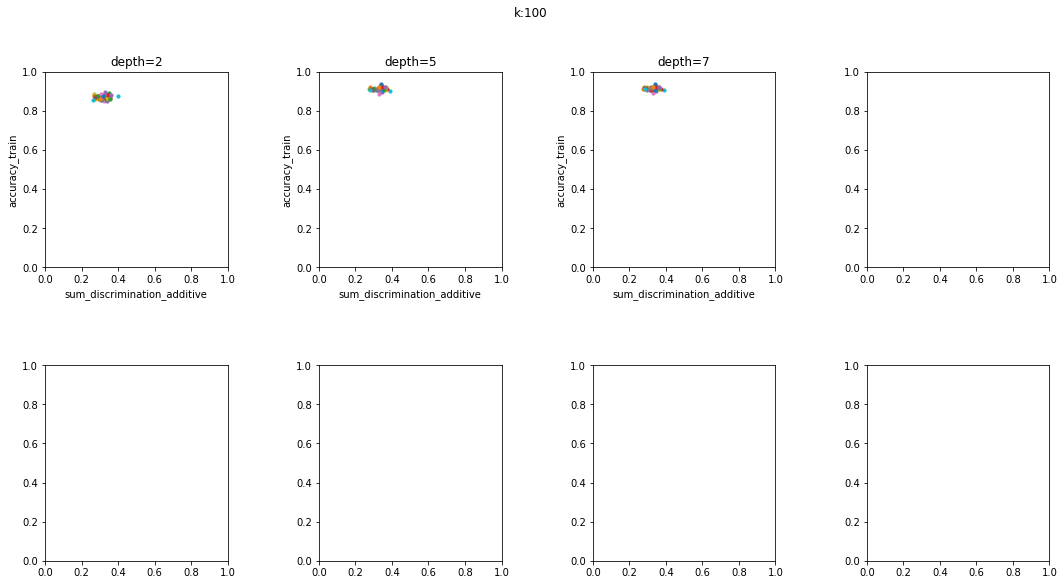

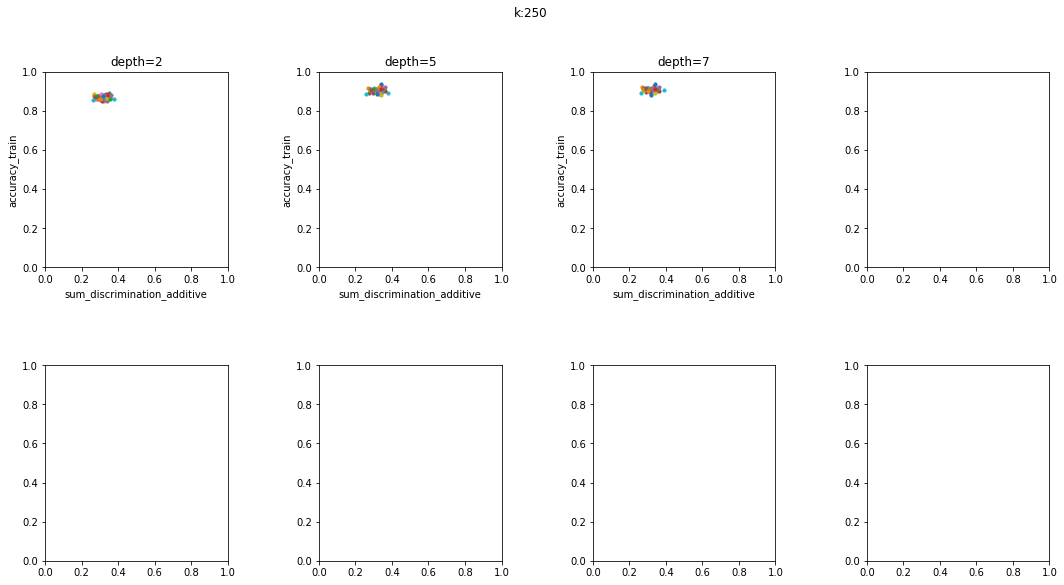

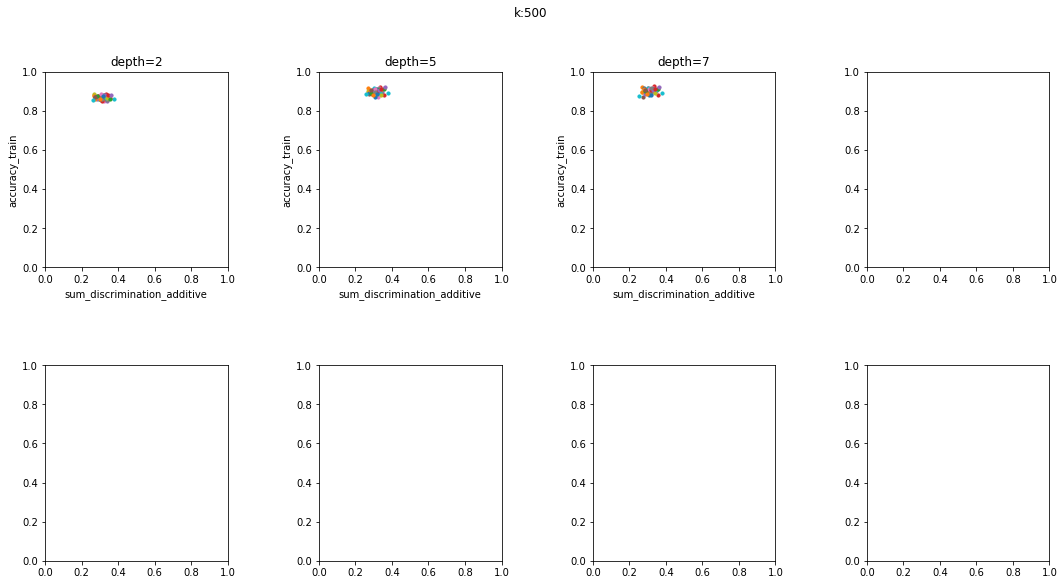

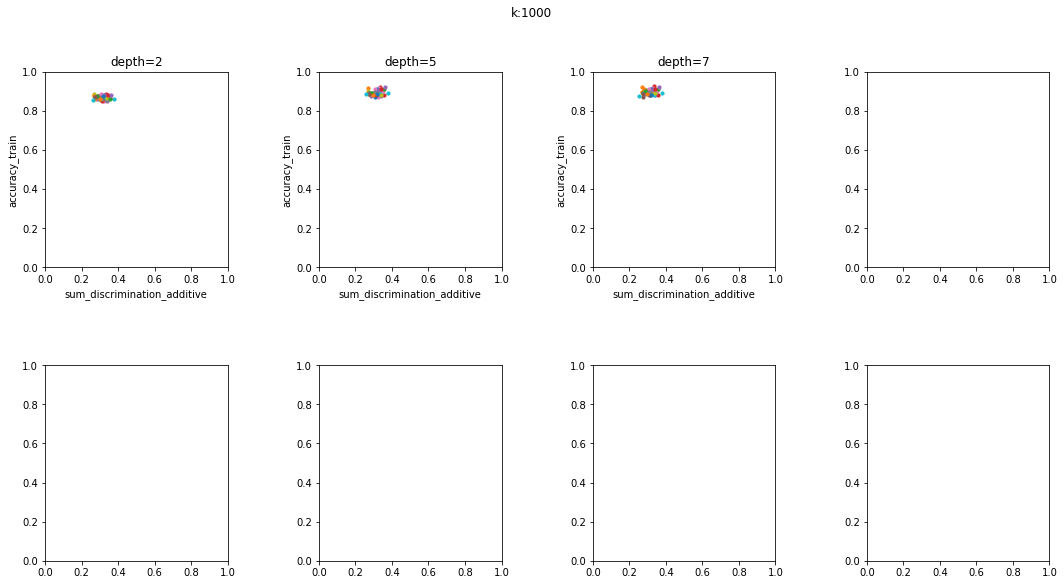

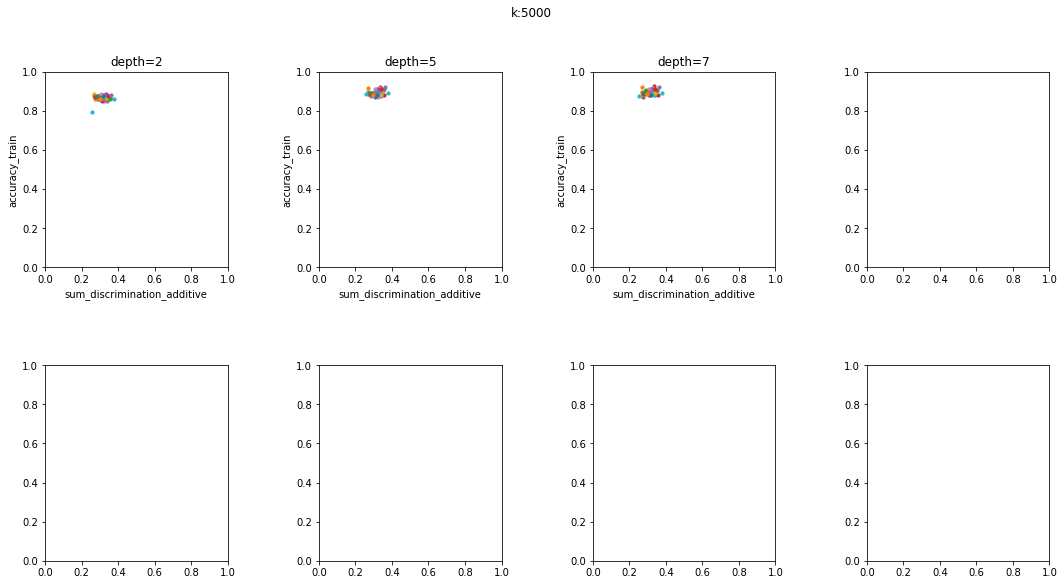

In [25]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive", "accuracy_train", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

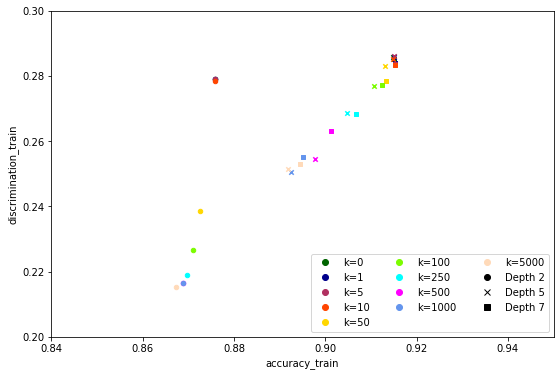

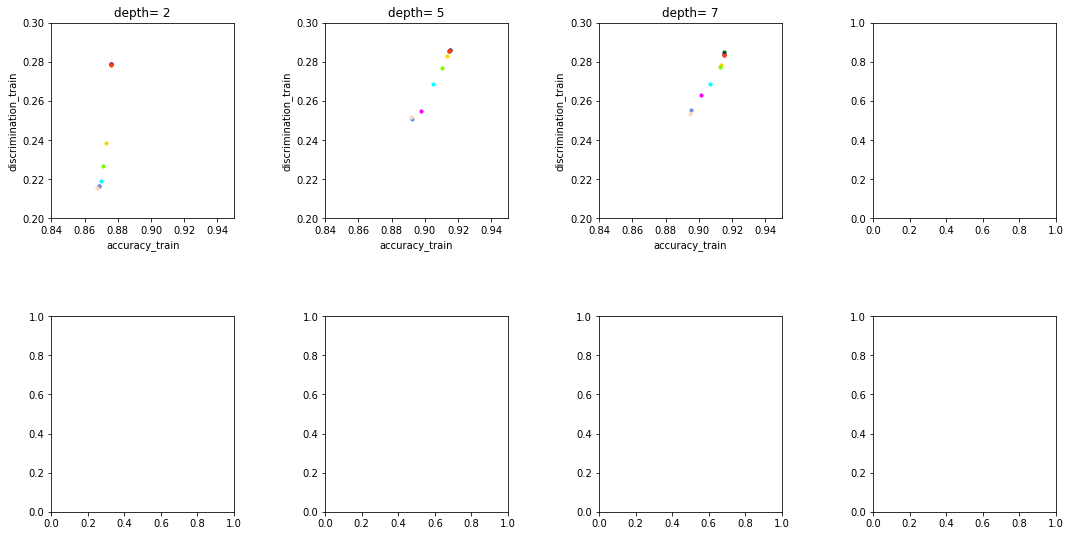

In [26]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_train", "discrimination_train", result, x_lim, y_lim)
#utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train", result, (0.70, 1), (0, 0.35))
utils.plot_each_k_depth_mean("accuracy_train", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

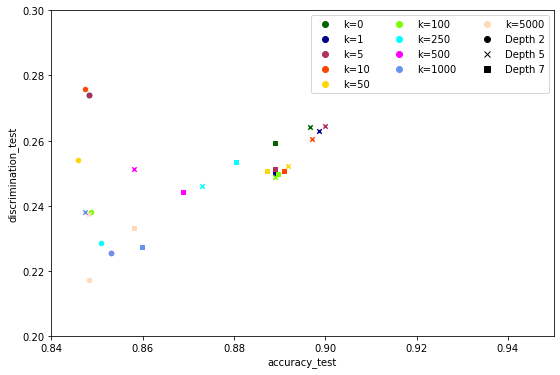

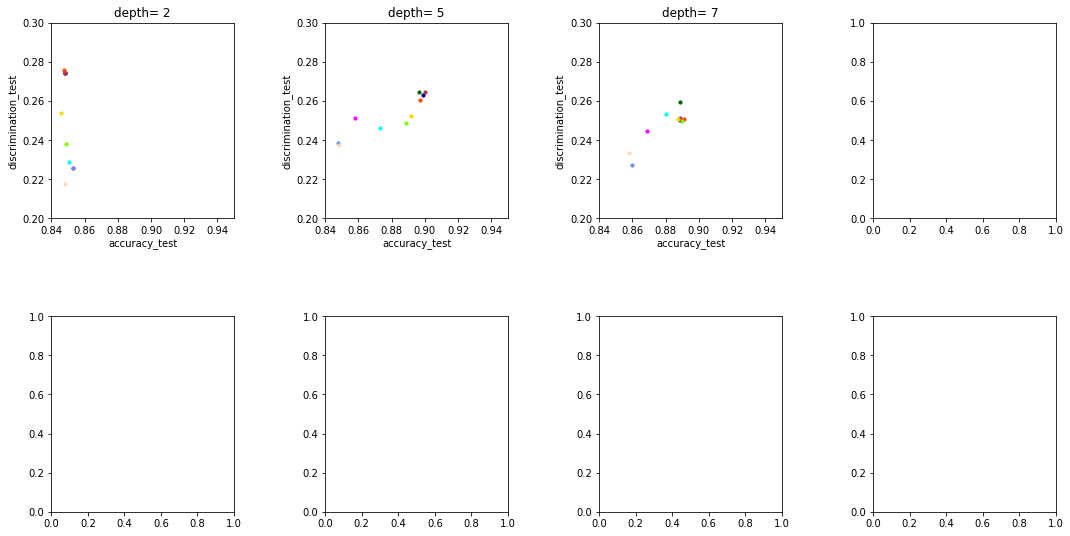

In [27]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

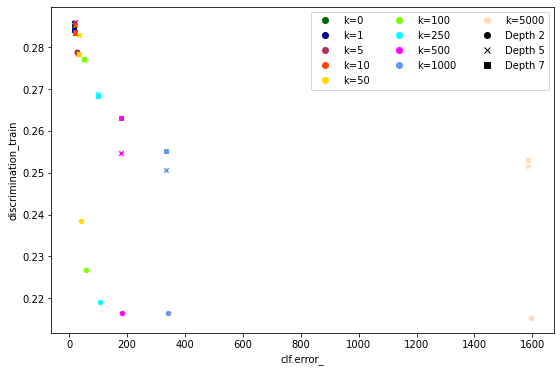

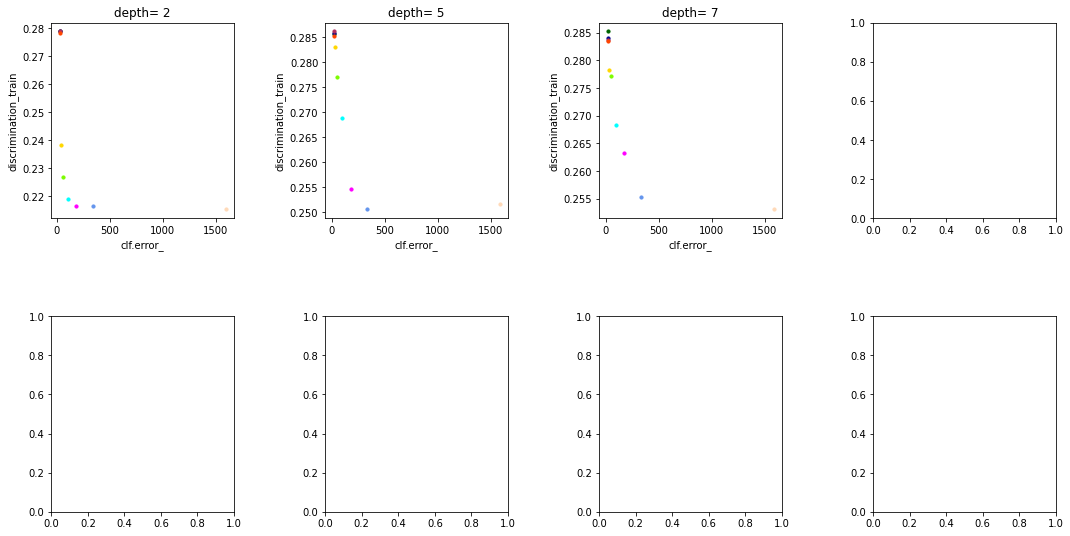

In [28]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

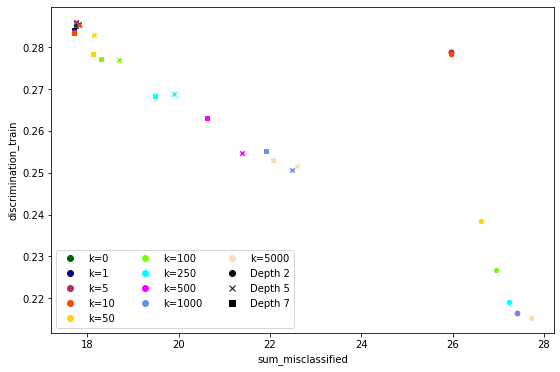

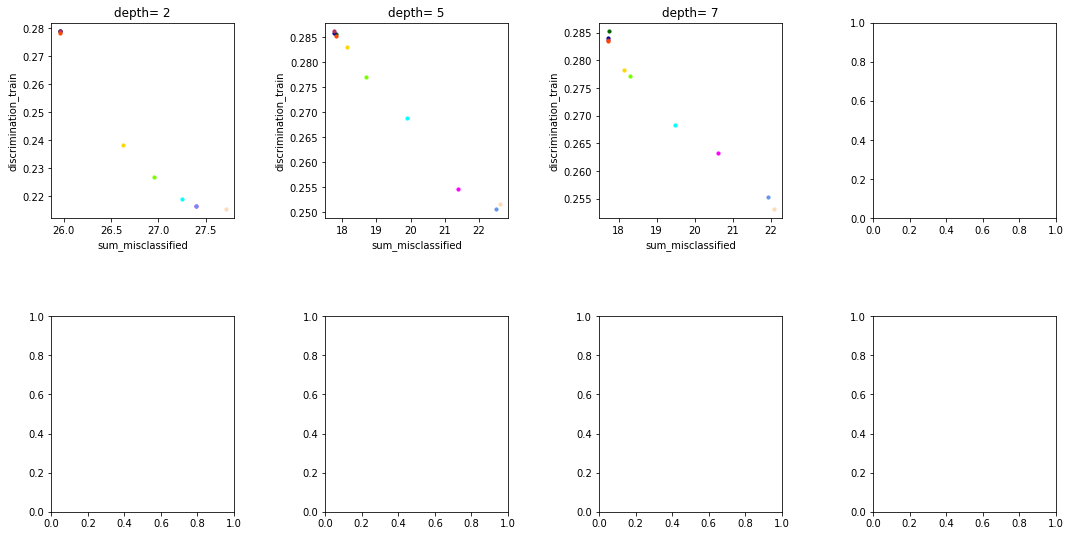

In [29]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified", "discrimination_train", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

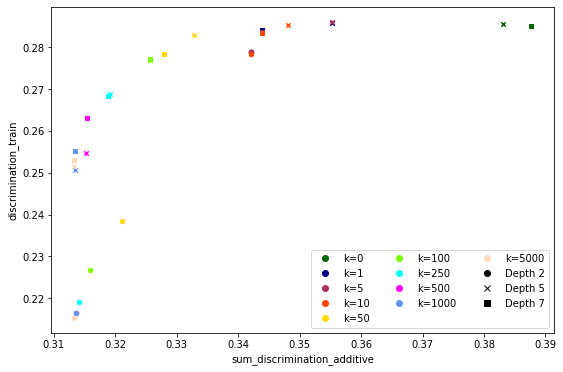

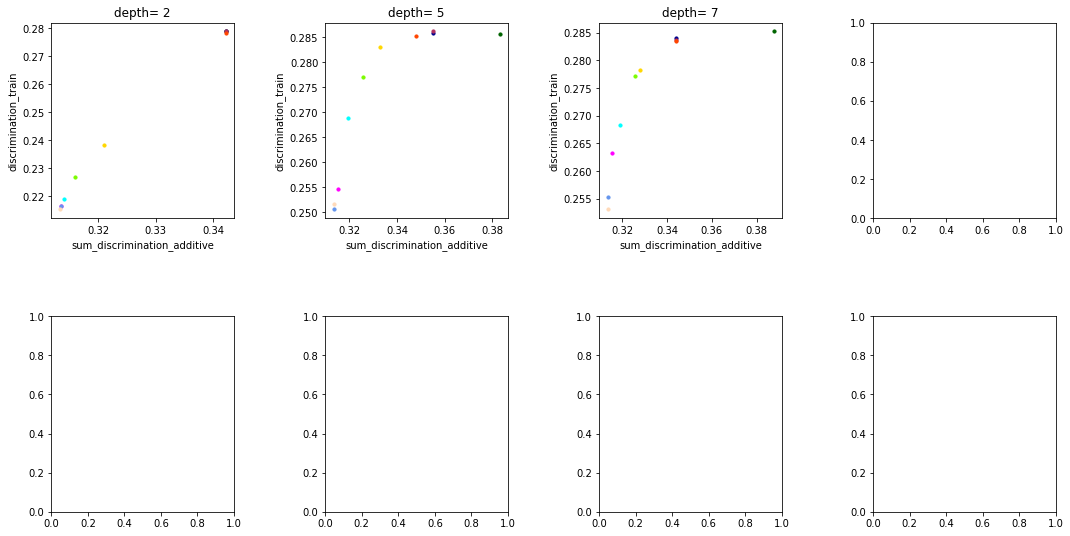

In [30]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive", "discrimination_train", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive", "discrimination_train", result, x_lim, y_lim)